Descarga datos de rayos X blandos de GOES para n días seleccionados de forma semi-aleatoria y espaciados uniformemente.

Organiza los días en carpetas por bloques de hasta chunk_size días.

Descarga en las mismas carpetas los catálogos de flares correspondientes a esas fechas.

Sustrae el background aplicando el método de diferencias móviles.

Calcula temperatura y medida de emisión.

Normaliza la medida de emisión.

Consolida todos los bloques en un único archivo con los resultados completos.

# Función completa 

Calcula hasta tiempos de anticipación del peak cambiando solo fecha y grafica los tiempos que se quieran 

## Paquetes

In [26]:
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
from sunpy.timeseries.sources.goes import XRSTimeSeries
import astropy.units as u
from sunkit_instruments.goes_xrs import calculate_temperature_em
import matplotlib.pyplot as plt
import numpy as np
from sunpy.data import manager
import netCDF4 as nc
import os
import pandas as pd
from datetime import datetime, timedelta
import copy
from matplotlib import colormaps
list(colormaps)
#from colorspacious import cspace_converter
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterMathtext
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import re
import glob

## Functions

In [27]:
##############################
##    1. Download GOES data   #
##############################

## 1.0. Ensure 1 min resolution
def ensure_1min_resolution(ts):
    """
    Revisa si el TimeSeries está en resolución de 1 minuto.
    Si no, lo re-muestrea a 1 min con la media.

    Check if the TimeSeries has a resolution of 1 minute.
    If no, it will be shown again in 1 minute with the media
    """
    # Pasar a DataFrame
    df = ts.to_dataframe()
    
    # Calcular la resolución actual (diferencia entre los 2 primeros tiempos)
    current_res = (df.index[1] - df.index[0]).total_seconds()
    
    if abs(current_res - 60) < 1:  # ya es 1 min (tolerancia de 1s)
        print("Resolution = 1 minute")
        return ts
    else:
        print(f"Resolution detected: {current_res:.2f} s → resampling at 1 min")
        df_resampled = df.resample("1min").mean()
        return TimeSeries(df_resampled, ts.meta)

## 1.1. Download data
def Download_Data(start_time, end_time, resolution="avg1m", log_file="errores_goes.log"):
    
    """
    Entrada / Input:
        start_time (str): Tiempo inicial del intervalo de búsqueda, en formato compatible con SunPy.
        end_time (str): Tiempo final del intervalo de búsqueda, en formato compatible con SunPy.
        resolution (str, opcional / optional): Resolución temporal de los datos GOES. 
            Opciones válidas: "flx1s", "avg1m". Por defecto es 'avg1m'.

    Salida / Output:
        TimeSeries: Objeto de SunPy que contiene los datos XRS del satélite GOES 
                    dentro del intervalo de tiempo especificado.
                    con la resolución especificada.

    Descripción / Description:
        Esta función busca, descarga y carga datos del instrumento GOES (X-Ray Sensor, XRS)
        en el intervalo de tiempo especificado y con la resolución deseada. Utiliza Fido para la búsqueda
        y retorna un objeto TimeSeries con los datos.

        This function searches for, downloads, and loads data from the GOES (X-Ray Sensor, XRS)
        within the specified time interval and chosen resolution. It uses Fido for querying and 
        returns a TimeSeries object with the data.
    """
    try:
        # Validar resolución / Validate resolution
        valid_resolutions = ["flx1s", "avg1m"]
        if resolution not in valid_resolutions:
            raise ValueError(f"Resolución no válida. Usa una de: {valid_resolutions}")

        # Buscar y descargar los datos de GOES / Search and download GOES data
        print(f"Buscando datos de: {start_time}")
        result = Fido.search(a.Time(start_time, end_time), a.Instrument.goes, a.Resolution(resolution))

        # Por si exiten días sin datos
        if len(result[0]) == 0 or len(result[0]) == 0:
            print(f"No hay datos GOES disponibles para {start_time} - {end_time}. Día saltado")
            msg = f" No hay datos GOES para {start_time} - {end_time}. Día saltado."
            print(msg)
            with open(log_file, "a") as f:
                f.write(msg + "\n")
            return None  
        

        print(f"Data found according to the date({start_time}): {result}")

        print(f"Downloading data of {start_time}: ")
        files = Fido.fetch(result)

        if len(files) == 0:
            print(f"No se descargaron archivos GOES para {start_time}. Día saltado.")
            return None
        
        # Cargar los datos en un TimeSeries / Load the data into a TimeSeries
        try:    # Intenta cargar el archivo descargado (files[0]) en un objeto TimeSeries de SunPy.
            print(f"Cargando datos de {start_time} en un TimeSeries:")
            ts = TimeSeries(files[0], source="XRS") # source="XRS" le dice a SunPy que lo interprete como datos del instrumento GOES/XRS.
        except Exception as e: # Si ocurre cualquier error durante la carga (archivo vacío, fechas inválidas, formato corrupto) el programa no se rompe.
            print(f" Error al abrir archivo GOES de {start_time}: {e}")
            msg = f" Error al abrir archivo GOES de {start_time}: {e}"
            print(msg)
            with open(log_file, "a") as f:
                f.write(msg + "\n")
            return None # En su lugar, imprime un aviso con el error y devuelve None
        
        print(f"Nos aseguramos que los datos de {start_time} tengan resolución de un min")
        goes_ts = ensure_1min_resolution(ts)
        
        print(f"Print data with 1 min resolution: {goes_ts}")
        goes_ts.peek()

        # Extraer el observatorio (ejemplo: "GOES-16")
        try:
            meta0 = goes_ts.meta.metas[0]
            platform = meta0["platform"]   # ej. "g16"
            numero = int("".join(filter(str.isdigit, platform)))
            observatory = f"GOES-{numero}"
        except Exception:
            observatory = None
        
        return goes_ts, observatory
    except Exception:
        return None, None   #  siempre devuelve una tupla



## 1.2. Truncar datos
def Truncate_Data(goes_ts, flare_start_time, flare_end_time):
    
    """
    Entrada / Input:
        goes_ts (TimeSeries): Objeto TimeSeries con los datos GOES completos.
        flare_start_time (str): Tiempo de inicio de la fulguración (en formato compatible con SunPy).
        flare_end_time (str): Tiempo de fin de la fulguración (en formato compatible con SunPy).

    Salida / Output:
        TimeSeries: Objeto TimeSeries con los datos recortados al intervalo de la fulguración.

    Descripción / Description:
        Esta función recorta un conjunto de datos GOES a un intervalo de tiempo específico
        correspondiente al inicio y fin de una fulguración solar. Si el intervalo no contiene datos,
        se lanza una excepción.

        This function trims a GOES TimeSeries dataset to a specific time interval
        corresponding to the start and end of a solar flare. If the interval contains no data,
        an exception is raised.
    """

    # Seleccionar el rango de interés / Select the time range of interest
    goes_flare = goes_ts.truncate(flare_start_time, flare_end_time)

    # Verificar si hay datos disponibles  / Check if data is available
    if len(goes_flare.to_dataframe()) == 0:
        raise ValueError("El rango de datos seleccionado está vacío. Revisa las fechas.")
        # The selected time range is empty. Please check the input times.

    # Visualizar los datos truncados / Plot the trimmed data
    goes_flare.peek()

    return goes_flare

## 2. Background
def running_difference(goes_ts, Dif_time=5, plot=False):
    """
    Calcula las diferencias de flujo de rayos X GOES a un intervalo definido (default 5 min).
    
    Parámetros
    ----------
    goes_ts : XRSTimeSeries
        Serie temporal original de GOES.
    Dif_time: int, optional
        Intervalo de diferencia en número de pasos para restar flux, y conseguir datos sin background(default=5).
    plot : bool, optional
        Si True, grafica comparación entre original y corregido.
        
    Retorna
    -------
    goes_diff_ts : XRSTimeSeries
        Serie temporal corregida con las diferencias.
    """

    # 1. Extraer datos como DataFrame
    df = goes_ts.to_dataframe()
    flux_xrsb = df["xrsb"]
    flux_xrsa = df["xrsa"]

    npts = len(df)

    # 2. Calcular diferencias
    diffa = np.array(flux_xrsa[Dif_time:]) - np.array(flux_xrsa[:npts - Dif_time])
    diffb = np.array(flux_xrsb[Dif_time:]) - np.array(flux_xrsb[:npts - Dif_time])

    # 3. Llenar arreglos completos con ceros hasta el Dif_time
    diffa_full = np.zeros(npts)
    diffb_full = np.zeros(npts)
    diffa_full[Dif_time:] = diffa
    diffb_full[Dif_time:] = diffb

    # 4. Crear nuevo DataFrame con el mismo índice de tiempo
    df_diff = pd.DataFrame(data={'xrsa': diffa_full, 'xrsb': diffb_full}, index=df.index)

    # 5. Crear un nuevo TimeSeries con las unidades correctas
    units = {'xrsa': u.W / u.m**2, 'xrsb': u.W / u.m**2}
    goes_diff_ts = XRSTimeSeries(df_diff, units=units, meta=goes_ts.meta)

    # 6. Graficar (opcional)
    if plot:
        df_original = df
        df_corr = goes_diff_ts.to_dataframe()

        plt.figure(figsize=(12, 6))

        # Canal XRSA
        plt.plot(df_original.index, df_original['xrsa'], label='XRSA original', color='blue')
        plt.plot(df_corr.index, df_corr['xrsa'], label='XRSA corregido', color='blue', linestyle='--')

        # Canal XRSB
        plt.plot(df_original.index, df_original['xrsb'], label='XRSB original', color='red')
        plt.plot(df_corr.index, df_corr['xrsb'], label='XRSB corregido', color='red', linestyle='--')

        plt.xlabel('Time')
        plt.ylabel('Flux [W/m²]')
        plt.title(f'GOES Data Comparison (Δt={Dif_time} steps)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return goes_diff_ts


#####################################
# 5. Temperatura y Emission Measure #
#####################################

## 5.1. Calcular la Temperatura y Medida de emisión con los datos corregidos
#Calculate_Tem_EM(goes_flare_corrected, abundance='photospheric')
#Calculate_Tem_EM(goes_flare_corrected, abundance='coronal')
def Calculate_Tem_EM(goes_flare_corrected, abundance='coronal'):
    
    """
    Entrada / Input:
        goes_flare_corrected: Objeto TimeSeries corregido que contiene los datos del flare solar en los
        canales XRSA y XRSB. Debe ser compatible con la función `calculate_temperature_em` de SunPy.
        abundance (str): Tipo de abundancia elemental a usar en el cálculo (por defecto: 'coronal').
                         Otras opciones posibles incluyen 'photospheric', dependiendo del modelo de SunPy.

    Salida / Output:
        temp_em: Objeto que contiene la temperatura (T) y medida de emisión (EM) derivadas a partir de los
        datos GOES corregidos.

    Descripción / Description:
        Esta función utiliza los datos corregidos del satélite GOES para calcular la temperatura del plasma
        y la medida de emisión (EM) durante un evento de fulguración solar. Permite especificar el modelo
        de abundancia elemental a utilizar en el cálculo.

        This function uses corrected GOES data to compute the plasma temperature and emission measure (EM)
        during a solar flare. It allows specifying the elemental abundance model to be used in the calculation.

    Notas / Notes:
        - Usa la función `calculate_temperature_em` de SunPy.
        - El parámetro `abundance` controla el modelo de abundancias (por ejemplo, 'coronal' o 'photospheric').
        - Se desactiva temporalmente la verificación del hash de calibración del instrumento.
        - Los datos deben estar previamente corregidos y limpios.
    """

    print(f'Ahora vamos a calcular la T y EM con el modelo de abundancias:{abundance}')
    #  Saltar la verificación del hash temporalmente
    with manager.skip_hash_check():
        #temp_em = calculate_temperature_em(goes_flare_corrected, abundance='coronal')
        temp_em = calculate_temperature_em(goes_flare_corrected, abundance)
    
    print(f'se calculó T y EM con el modelo de abundancias:{abundance}')
    print(temp_em)
    return temp_em


# mostrar un rango de datos de un TimeSeries
def show_range_ts(ts, start_idx, end_idx, height=300):
    df = ts.to_dataframe()
    subdf = df.iloc[start_idx:end_idx]
    display(HTML(f"""
    <div style="height:{height}px; overflow:auto; border:1px solid #ccc; padding:10px">
        {subdf.to_html()}
    </div>
    """))

# Uso:
#show_range_ts(goes_ts01, 0, 10)

#####################################
#     6. Calcula tiempos de FAI     #
#####################################

def calcular_fai_times(df, 
                       T_min=7, T_max=14, 
                       EM_threshold=0.005, 
                       col_T="T_cor", 
                       col_EM="EM_cor_norm"):
    """
    Calcula los tiempos en los que se cumplen los criterios del índice FAI.
    """

    # Copiar para no modificar el original
    df_fai = df.copy()

    # Condiciones del criterio FAI
    fai_condition = (
        (df_fai[col_T] >= T_min) & 
        (df_fai[col_T] <= T_max) & 
        (df_fai[col_EM] > EM_threshold)
    )

    # Selección
    df_fai_selected = df_fai[fai_condition]
    fai_times = df_fai_selected.index

    # Mostrar los resultados como en tu código original
    print(f"Se encontraron {len(df_fai_selected)} puntos que cumplen el criterio FAI.\n")
    print(df_fai_selected[[col_T, col_EM]].head())

    return fai_times, df_fai_selected

########################
# 7. Descargar Flares #
#######################

## 7.1. Descarga de datos de flares
def get_flares(start_time, end_time):
    # Buscar fulguraciones solares
    print("Search flares")
    result = Fido.search(a.Time(start_time, end_time), a.hek.FL, 
                        a.hek.OBS.Observatory == "GOES" )   # Para filtrar solo flares de GOES 
    print("It found?")
    #Verifica si encontró flares:
    if len(result[0]) == 0:
        print(f"No solar flares were found between {start_time} and {end_time}.")
        return None
    print("YES, It found")
    # Filtrar nombres de columnas que sean 1D
    names = [name for name in result[0].colnames if len(result[0][name].shape) <= 1]
    print("filter")
    # Convertir a DataFrame solo las columnas 1D
    table = result[0][names].to_pandas()
    print("Create dataframe")
    # Seleccionar solo las columnas que te interesan
    flare_data = table[[
        "event_starttime",
        "event_endtime",
        "fl_goescls",
        "obs_observatory",
        "event_peaktime"
    ]]
    print("table")
    # Renombrar columnas
    flare_data.columns = ["StartTime", "EndTime", "Class", "Observatory", "PeakTime"]

    # Imprimir número de flares encontrados
    print(f"Se encontraron {len(flare_data)} fulguraciones solares entre {start_time} y {end_time}.")

    return flare_data
    

######################
# 8. Graphs #
#######################

# Plot with ticks every minute
def plot_fai_and_flare_lines(df_combined, df_fai_selected, df_flare_data, 
                              flare_start_time, flare_end_time,
                              ymin=1e-9, ymax=1e-4):
    """
    Plots XRS A and B on a logarithmic scale with vertical lines for FAI events and flare peaks.

    Parameters:
    - df_combined: DataFrame with 'xrsa' and 'xrsb' columns and a DatetimeIndex.
    - df_fai_selected: DataFrame with temporal index for FAI events.
    - df_flare_data: DataFrame with 'event_peaktime' and 'Class' columns.
    - flare_start_time (str or pd.Timestamp): Start time of the plot interval.
    - flare_end_time (str or pd.Timestamp): End time of the plot interval.
    - ymin (float): Lower limit for y-axis (log scale).
    - ymax (float): Upper limit for y-axis (log scale).
    """
    # Ensure time types
    flare_start_time = pd.to_datetime(flare_start_time)
    flare_end_time = pd.to_datetime(flare_end_time)

    # Filter data
    df_plot = df_combined.loc[flare_start_time:flare_end_time]
    df_fai_interval = df_fai_selected.loc[flare_start_time:flare_end_time]

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 3.5))

    # Plot XRS A and B
    ax.plot(df_plot.index, df_plot['xrsa'], label='XRS A', color='blue')
    ax.plot(df_plot.index, df_plot['xrsb'], label='XRS B', color='red')

    # Log scale and Y-axis limits
    ax.set_yscale('log')
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel('X-ray Flux [W/m²]')
    ax.set_xlabel('Time [UTC]')
    ax.set_title('XRS A and B with FAI and Flare Peak Lines (7 < T < 14 MK and EM > 0.005)')
    ax.grid(True)

    # Red vertical lines: FAI events
    for fai_time in df_fai_interval.index:
        ax.axvline(x=fai_time, color='red', linestyle='-', linewidth=1.5, alpha=0.6)

    # Blue dashed vertical lines: flare peaks + class labels
    for _, row in df_flare_data.iterrows():
        peak_time = row['PeakTime']
        flare_class = row.get('Class', '')
        if flare_start_time <= peak_time <= flare_end_time:
            ax.axvline(x=peak_time, color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
            if flare_class:
                ax.annotate(flare_class,
                            xy=(peak_time, ymin * 5),
                            xytext=(peak_time + pd.Timedelta(minutes=0.2), ymin * 10),
                            fontsize=8,
                            color='blue',
                            rotation=0,
                            ha='left',
                            va='center',
                            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="blue", lw=0.5, alpha=0.6))

    # X-axis ticks
    major_locator = mdates.MinuteLocator(byminute=range(0, 60, 10), interval=1)
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=range(0, 60, 1)))
    ax.tick_params(axis='x', which='major', length=6)
    ax.tick_params(axis='x', which='minor', length=4, color='gray')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Final layout
    ax.legend(loc="upper right")
    fig.tight_layout()
    plt.show()

# Plot with Auto ticks for time axis
def plot_fai_and_flare_lines2(df_combined, df_fai_selected, df_flare_data, 
                              flare_start_time, flare_end_time,
                              ymin=1e-9, ymax=1e-4):
    """
    Plots XRS A and B on a logarithmic scale with vertical lines for FAI events and flare peaks.
    """
    # Ensure time types
    flare_start_time = pd.to_datetime(flare_start_time)
    flare_end_time = pd.to_datetime(flare_end_time)

    # Filter data
    df_plot = df_combined.loc[flare_start_time:flare_end_time]
    df_fai_interval = df_fai_selected.loc[flare_start_time:flare_end_time]

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 3.5))

    # Plot XRS A and B
    ax.plot(df_plot.index, df_plot['xrsa'], label='XRS A', color='blue')
    ax.plot(df_plot.index, df_plot['xrsb'], label='XRS B', color='red')

    # Log scale and Y-axis limits
    ax.set_yscale('log')
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel('X-ray Flux [W/m²]')
    ax.set_xlabel('Time [UTC]')
    ax.set_title('XRS A and B with FAI and Flare Peak Lines (7 < T < 14 MK and EM > 0.005)')
    ax.grid(True)

    # Red vertical lines: FAI events
    for fai_time in df_fai_interval.index:
        ax.axvline(x=fai_time, color='red', linestyle='-', linewidth=1.5, alpha=0.6)

    # Blue dashed vertical lines: flare peaks + class labels
    for _, row in df_flare_data.iterrows():
        peak_time = row['PeakTime']
        flare_class = row.get('Class', '')
        if flare_start_time <= peak_time <= flare_end_time:
            ax.axvline(x=peak_time, color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
            if flare_class:
                ax.annotate(flare_class,
                            xy=(peak_time, ymin * 5),
                            xytext=(peak_time + pd.Timedelta(minutes=0.2), ymin * 10),
                            fontsize=8,
                            color='blue',
                            rotation=0,
                            ha='left',
                            va='center',
                            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="blue", lw=0.5, alpha=0.6))

    # Auto ticks for time axis
    locator = mdates.AutoDateLocator()
    formatter = mdates.AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Final layout
    ax.legend(loc="upper right")
    fig.tight_layout()
    plt.show()

# Plot T vs EM  con uno (coronal o fotosférico) o ambos modelos
def plot_T_vs_EM(df_full,
                 model="cor",   # "cor", "phot" or "both"
                 time_colors=None, 
                 title="", method_name="", integration_time="",
                 T_min=5, T_max=30, EM_min=1e46, EM_max=1e50,
                 temp_threshold=30, color_by_time=True,
                 start_time=None, end_time=None):
    """
    Plot Temperature vs Emission Measure (EM) from a DataFrame containing both models.

    Parameters
    ----------
    df_full : pandas.DataFrame
        DataFrame with columns ['T_cor','EM_cor','T_phot','EM_phot'].
    model : str, default="cor"
        Which model to plot: "cor" (coronal), "phot" (photospheric), or "both".
    time_colors : str or None
        Time limit to split colors (format 'YYYY-MM-DD HH:MM:SS').
    title : str
        Plot title.
    method_name : str
        Method label for the title.
    integration_time : str
        Integration time label for the title.
    T_min, T_max : float
        Limits for the temperature axis (MK).
    EM_min, EM_max : float
        Limits for the EM axis (cm⁻³, log scale).
    temp_threshold : float
        Maximum temperature (MK) to filter values.
    color_by_time : bool
        If True, color points by elapsed time (only applies to a single model).
    start_time, end_time : str or None
        Time interval to crop the DataFrame ('YYYY-MM-DD HH:MM:SS').

    Output
    ------
    None (shows a matplotlib plot).
    """

    # Crop DataFrame by time interval if specified
    if start_time is not None:
        start_time = pd.to_datetime(start_time)
        df_full = df_full[df_full.index >= start_time]
    if end_time is not None:
        end_time = pd.to_datetime(end_time)
        df_full = df_full[df_full.index <= end_time]

    plt.figure(figsize=(6, 5))
    t0 = df_full.index[0]

    # ---- Coronal model ----
    if model in ["cor", "both"]:
        T_cor = df_full["T_cor"].to_numpy()
        EM_cor = df_full["EM_cor"].to_numpy()
        elapsed_time = (df_full.index - t0).total_seconds()

        mask_cor = T_cor < temp_threshold
        T_cor, EM_cor, time_cor = T_cor[mask_cor], EM_cor[mask_cor], elapsed_time[mask_cor]

        if model == "cor" and color_by_time and time_colors is not None:
            limit_dt = datetime.strptime(time_colors, "%Y-%m-%d %H:%M:%S")
            limit_seconds = (limit_dt - t0).total_seconds()
            mask_colored = time_cor <= limit_seconds
            mask_gray = time_cor > limit_seconds

            sc = plt.scatter(EM_cor[mask_colored], T_cor[mask_colored],
                             c=time_cor[mask_colored],
                             cmap="viridis", marker="+", s=30)
            plt.scatter(EM_cor[mask_gray], T_cor[mask_gray],
                        color="gray", marker=".", s=5)

            cbar = plt.colorbar(sc)
            cbar.set_label("Time since start (s)")
        else:
            plt.scatter(EM_cor, T_cor, color="red", marker="o", s=12, label="Coronal")

    # ---- Photospheric model ----
    if model in ["phot", "both"]:
        T_phot = df_full["T_phot"].to_numpy()
        EM_phot = df_full["EM_phot"].to_numpy()
        elapsed_time = (df_full.index - t0).total_seconds()

        mask_phot = T_phot < temp_threshold
        T_phot, EM_phot, time_phot = T_phot[mask_phot], EM_phot[mask_phot], elapsed_time[mask_phot]

        if model == "phot" and color_by_time and time_colors is not None:
            limit_dt = datetime.strptime(time_colors, "%Y-%m-%d %H:%M:%S")
            limit_seconds = (limit_dt - t0).total_seconds()
            mask_colored = time_phot <= limit_seconds
            mask_gray = time_phot > limit_seconds

            sc = plt.scatter(EM_phot[mask_colored], T_phot[mask_colored],
                             c=time_phot[mask_colored],
                             cmap="viridis", marker="+", s=30)
            plt.scatter(EM_phot[mask_gray], T_phot[mask_gray],
                        color="gray", marker=".", s=5)

            cbar = plt.colorbar(sc)
            cbar.set_label("Time since start (s)")
        else:
            plt.scatter(EM_phot, T_phot, color="blue", marker="^", s=12, label="Photospheric")

    # ---- Plot adjustments ----
    plt.xscale("log")
    plt.xlim(EM_min, EM_max)
    plt.ylim(T_min, T_max)
    plt.xlabel("EM (cm⁻³)")
    plt.ylabel("Temperature (MK)")
    plt.title(rf"{title} - {method_name}, Δt={integration_time}")
    if model == "both":
        plt.legend()
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


######################################
# 8. Tiempo de Anticipacion de flare #
######################################

def anticipation_fai_block_df_only(fai_times, df_flare_data, peak_time_column="event_peaktime", 
                                   show_all=False, max_gap_minutes=5):
    """
    Calcula el tiempo de anticipación desde el primer FAI de una secuencia continua anterior al flare.
    
    Parámetros:
    - fai_times: lista o serie de timestamps (DatetimeIndex o similar)
    - df_flare_data: DataFrame con columna de tiempo pico del flare
    - peak_time_column: nombre de la columna con los tiempos de pico del flare
    - show_all: si False, descarta flares sin FAI anterior
    - max_gap_minutes: tiempo máximo entre FAIs para considerarlos parte del mismo grupo

    Retorna:
    - df_flare_data con dos nuevas columnas:
        - 'Anticipation (min)': tiempo entre el FAI más antiguo del grupo y el pico del flare
        - 'Previous FAI': timestamp del FAI más antiguo del grupo
    """
    df_flare_data = df_flare_data.copy()
    df_flare_data[peak_time_column] = pd.to_datetime(df_flare_data[peak_time_column])
    fai_times = pd.to_datetime(fai_times).sort_values()

    anticipation_minutes = []
    used_fai = []

    for peak_time in df_flare_data[peak_time_column]:
        # 1. Obtener solo FAIs que ocurrieron antes del pico del flare
        previous_fais = fai_times[fai_times < peak_time]

        if not previous_fais.empty:
            # 2. Calcular diferencias de tiempo entre FAIs consecutivos en minutos
            diffs = previous_fais.to_series().diff().dt.total_seconds().div(60).fillna(0)

            # 3. Identificar grupos de FAIs separados por más de 'max_gap_minutes'
            group_ids = (diffs > max_gap_minutes).cumsum()

            # 4. Obtener el grupo más reciente (último grupo antes del pico)
            last_group = group_ids.iloc[-1]
            group_fais = previous_fais[group_ids == last_group]

            # 5. Seleccionar el FAI más antiguo de ese grupo como punto de anticipación
            earliest_fai = group_fais.min()
            anticipation = (peak_time - earliest_fai).total_seconds() / 60.0

            anticipation_minutes.append(anticipation)
            used_fai.append(earliest_fai)
        else:
            anticipation_minutes.append(None)
            used_fai.append(None)

    # 6. Agregar resultados al DataFrame
    df_flare_data["Anticipation (min)"] = anticipation_minutes
    df_flare_data["Previous FAI"] = used_fai

    # 7. Filtrar si se desea solo flares con anticipación válida
    if not show_all:
        df_flare_data = df_flare_data[df_flare_data["Anticipation (min)"].notna()]

    return df_flare_data

## Join in one dataframe

def build_full_dataframe(goes_resampled, goes_corrected, temp_em_cor, temp_em_phot,
                         clip_negative=True):
    """
    Combina datos originales, corregidos y parámetros de temperatura/EM
    en un solo DataFrame.

    Parámetros
    ----------
    goes_resampled : sunpy.timeseries.TimeSeries
        Serie temporal GOES remuestreada (contiene 'xrsa', 'xrsb').
    goes_corrected : sunpy.timeseries.TimeSeries
        Serie temporal con GOES corregido (xrsa, xrsb corregidos).
    temp_em_cor : sunpy.timeseries.TimeSeries
        Serie temporal con temperatura y EM coronal.
    temp_em_phot : sunpy.timeseries.TimeSeries
        Serie temporal con temperatura y EM fotosférica.
    clip_negative : bool, opcional
        Si True, corrige valores negativos en T y EM poniéndolos en 0.

    Retorna
    -------
    pd.DataFrame
        DataFrame combinado con todas las columnas.
    """

    # Originales
    df_original = goes_resampled.to_dataframe()[['xrsa', 'xrsb']]

    # Corregidos
    df_corr = goes_corrected.to_dataframe().rename(
        columns={'xrsa': 'xrsa_corr', 'xrsb': 'xrsb_corr'}
    )

    # Coronal
    df_cor = temp_em_cor.to_dataframe()[['temperature', 'emission_measure']].rename(
        columns={'temperature': 'T_cor', 'emission_measure': 'EM_cor'}
    )

    # Fotosférica
    df_phot = temp_em_phot.to_dataframe()[['temperature', 'emission_measure']].rename(
        columns={'temperature': 'T_phot', 'emission_measure': 'EM_phot'}
    )

    # Combinar todo
    df_full = pd.concat([df_original, df_corr, df_cor, df_phot], axis=1)

    # Opcional: corregir valores negativos
    if clip_negative:
        df_full[['T_cor', 'T_phot']] = df_full[['T_cor', 'T_phot']].clip(lower=0)
        df_full[['EM_cor', 'EM_phot']] = df_full[['EM_cor', 'EM_phot']].clip(lower=0)

    return df_full




# Revisa si hay un FAI en una ventana antes de cada flare
def check_fai_before_flare(fai_times, df_flare_data, flare_time_column="PeakTime", window_minutes=10):
    """
    Para cada flare, determina si hubo un FAI en los 'window_minutes' previos al flare.

    Agrega columnas:
      - FAI_before_flare: bool (True si hubo al menos un FAI en la ventana)
      - FAI_first_time: primer FAI en la ventana
      - FAI_last_time: último FAI en la ventana
      - FAI_count: número total de FAIs en la ventana
    """
    results = df_flare_data.copy()

    results["FAI_before_flare"] = False
    results["FAI_first_time"] = pd.NaT
    results["FAI_last_time"] = pd.NaT
    results["FAI_count"] = 0

    for idx, row in results.iterrows():
        flare_time = pd.to_datetime(row[flare_time_column])

        window_start = flare_time - pd.Timedelta(minutes=window_minutes)
        window_end = flare_time

        fais_in_window = fai_times[(fai_times >= window_start) & (fai_times < window_end)]

        if len(fais_in_window) > 0:
            results.at[idx, "FAI_before_flare"] = True
            results.at[idx, "FAI_first_time"] = fais_in_window.min()
            results.at[idx, "FAI_last_time"] = fais_in_window.max()
            results.at[idx, "FAI_count"] = len(fais_in_window)

    return results


# agrupa por clases de flares en 2 grupos por clase
def assign_flare_group(flare_class):
    """
    Asigna un grupo a un flare según su clase y subnivel.
    
    Ejemplos:
    - C3.0 → C1-4
    - C7.5 → C5-9
    - X2.0 → X1-4
    - X7.0 → X5+
    """
    group_ranges = {
        "A": [(1, 4), (5, 9)],
        "B": [(1, 4), (5, 9)],
        "C": [(1, 4), (5, 9)],
        "M": [(1, 4), (5, 9)],
        "X": [(1, 4), (5, 1000)]  # 1000 actúa como "infinito"
    }

    try:
        letter = flare_class[0]  # A, B, C, M, X
        number = float(flare_class[1:])  # acepta decimales, ej: "2.7" → 2.7
    except:
        return flare_class  # si algo raro viene en el CSV

    if letter not in group_ranges:
        return flare_class

    for (low, high) in group_ranges[letter]:
        if low <= number <= high:
            if high >= 1000:  # caso abierto (ej: X5+)
                return f"{letter}{low}+"
            return f"{letter}{low}-{high}"
    
    return flare_class


#######################
### cuenta los días ###
#######################

def count_days(start_date, end_date):
    """
    Counts the number of days between two dates.

    Parameters:
    - start_date (str): Start date in 'YYYY-MM-DD' format
    - end_date (str): End date in 'YYYY-MM-DD' format

    Returns:
    - int: Number of days between start_date and end_date
    """
    # Convert the strings to datetime objects
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Calculate the difference
    difference = end - start
    
    return difference.days

# Example usage
#days = count_days("1980-01-05", "2025-08-20")
#print(f"Days between the dates: {days}")


#############################################
# elige los días cada cierto paso según     #
# el número de días que quiera analizar (n) #
#############################################

def select_dates(start_date, end_date, n=10):
    """
    Selects n dates evenly spaced between start_date and end_date.

    Parameters:
    - start_date (str): Start date in 'YYYY-MM-DD' format
    - end_date (str): End date in 'YYYY-MM-DD' format
    - n (int): Number of dates to select (default 10)

    Returns:
    - list of str: List of dates in 'YYYY-MM-DD' format
    """
    # Convert strings to datetime objects
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Calculate total number of days
    total_days = (end - start).days
    
    # Calculate integer step
    step = total_days // (n - 1)  # n-1 intervals for n dates
    
    # Generate the dates
    dates = [start + timedelta(days=i*step) for i in range(n)]
    
    # Convert to strings
    return [d.strftime("%Y-%m-%d") for d in dates]


# guarda los datos seleccionados segun el paso en un df
def dates_to_dataframe(dates_list):
    """
    Converts a list of dates into a DataFrame with start_time and end_time.

    Parameters:
    - dates_list (list of str): List of dates in 'YYYY-MM-DD' format

    Returns:
    - pd.DataFrame: DataFrame with columns ['start_time', 'end_time']
    """
    data = {
        "start_time": [f"{date} 00:00:00" for date in dates_list],
        "end_time":   [f"{date} 23:59:00" for date in dates_list]
    }
    return pd.DataFrame(data)


# Divide un dateframen en lotes:
def chunk_dataframe(df, chunk_size=20):
    """
    Divide un DataFrame en bloques (chunks) de tamaño chunk_size.
    Devuelve una lista de DataFrames.
    """
    return [df.iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size)]

# unir todos los bloques al final
def combine_blocks(output_dir, pattern, final_name):
    """
    Une todos los CSV de bloques en un único archivo final.
    """
    files = sorted(glob.glob(os.path.join(output_dir, "**", f"*{pattern}*.csv"), recursive=True)) # revisa archivos en la carpera en el output_dir
                                                                        # toma los que contienen el texto "pattern" en su nombre
    df_list = [pd.read_csv(f) for f in files] # los abre con pandas y guarda en df_list
    if df_list:
        combined = pd.concat(df_list, ignore_index=True)                # une todos los dataframes en uno solo, en "combined"
        combined.to_csv(os.path.join(output_dir, final_name), index=False) # guarda en csv combined en el output_dir
        print(f" {final_name} creado con {len(combined)} filas (desde {len(files)} archivos).")
    else:
        print(f" No se encontraron archivos con patrón {pattern}")

# Example usage
#dates_list = select_dates("1980-01-05", "2025-08-20", n=10)
#df_intervals = dates_to_dataframe(dates_list)

#print(df_intervals)



## Prueba función completa

In [28]:
def download_goes_flare_data(start_time, end_time, 
                      resolution="avg1m",  #resolución de descarga de los datos GOES (1min)
                      Dif_time=5,            #Difference time Δt (for background)
                      plot_diff=True):
    """
    Pipeline completo para análisis de datos GOES y cálculo de FAI y anticipación.

    Parámetros:
    -----------
    start_time : str
        Tiempo inicial (ej: "2017-09-06 12:00:00")
    end_time : str
        Tiempo final (ej: "2017-09-06 12:15:00")
    resolution : str, opcional
        Resolución de datos GOES, default "avg1m". Opciones: ["flx1s", "avg1m"]
    Dif_time : int, opcional
        Ventana en pasos para calcular diferencias (default 5).
    plot_diff : bool, opcional
        Si True, grafica las diferencias calculadas.
    
    Retorna:
    --------
    dict con:
        - df_full : DataFrame con todos los cálculos
        - df_flare_data : DataFrame de flares GOES en el intervalo
    """

    # 1. Descargar datos GOES
    print("1. Descargar datos GOES")
    data = Download_Data(start_time, end_time, resolution)
    # para días sin datos GOES
    if data is None:
        print(f"No hay datos GOES para {start_time} - {end_time}. Día saltado.\n")
        return None
    else:
        print(f"Se encontraron datos  GOES para {start_time} - {end_time}. Día saltado.\n")
        goes_ts, observatory = data
        # Convertir TimeSeries a DataFrame para inspección
        df_goes = goes_ts.to_dataframe()

        # Número de registros
        print(f"Número de registros: {len(df_goes)}")

        # Columnas disponibles
        print(f"Columnas disponibles: {list(df_goes.columns)}")
        
    print("2. Restar Background")
    # 2. Calcular diferencias
    goes_ts_corrected_diff = running_difference(goes_ts, Dif_time=Dif_time, plot=plot_diff)

    # 3. Calcular T y EM (coronal y fotosférico)
    print("3. USAR FUNCIÓN SUNPY calculate_t_em")
    temp_em_cor = Calculate_Tem_EM(goes_ts_corrected_diff, abundance='coronal')
    temp_em_phot = Calculate_Tem_EM(goes_ts_corrected_diff, abundance='photospheric')

    print("4. CONSTRUIR df_full")
    # 4. Construir dataframe completo
    df_full = build_full_dataframe(goes_ts, goes_ts_corrected_diff, temp_em_cor, temp_em_phot)
    # 4. Construir dataframe completo
    df_full = build_full_dataframe(goes_ts, goes_ts_corrected_diff, temp_em_cor, temp_em_phot)

    print(f"añadiendo observatorio: GOES: {observatory}")
    # 5. Añadir columna del observatorio
    df_full["observatory"] = observatory
    # Reemplazar NaN por "Unknown"
    df_full["observatory"] = df_full["observatory"].fillna("Unknown")
    # Mover "observatory" al inicio
    cols = ["observatory"] + [col for col in df_full.columns if col != "observatory"]
    df_full = df_full[cols]
    print(df_full)
    # 5. Normalizar EM
    df_full['EM_cor_norm'] = df_full['EM_cor'] / 1e49
    df_full['EM_phot_norm'] = df_full['EM_phot'] / 1e49
    
    # 6. Descargar flares
    flare_data = get_flares(start_time, end_time)
    
    #verifica si encontró flares para el día
    if flare_data is None:
        print(f"No se encontraron flares para el intervalo {start_time} - {end_time}. Saltando...")
        # Crear DataFrames vacíos para todos los resultados que dependen de flares
        df_flare_data = pd.DataFrame()
        
        
        # Retornar diccionario con flares vacíos
        return {
            "df_full": df_full,
            "df_flare_data": df_flare_data,
        }
    

    # Si flare_data no es None continúa
    df_flare_data = flare_data[
        flare_data['Class'].notna() & 
        (flare_data['Class'].str.strip() != "") &
        (flare_data['Observatory'] == "GOES")
    ]

      

    # Retornar todo como dict
    return {
        "df_full": df_full,
        "df_flare_data": df_flare_data,
    }

## Count days

In [29]:
n=15

In [30]:
# contamos cuantos días hay desde la primera fecha 1980-01-05 hasta hoy

days = count_days("1980-01-05", "2025-08-19")
print(f"Days between the dates: {days}")

paso = days/n
paso

Days between the dates: 16663


1110.8666666666666

In [31]:

dates_list = select_dates("1980-01-05", "2025-08-19", n=n)
print(dates_list)

['1980-01-05', '1983-04-09', '1986-07-12', '1989-10-14', '1993-01-16', '1996-04-20', '1999-07-24', '2002-10-26', '2006-01-28', '2009-05-02', '2012-08-04', '2015-11-07', '2019-02-09', '2022-05-14', '2025-08-16']


## New folder for data

In [32]:
# Obtener fecha actual en formato YYYY-MM-DD
fecha_actual = datetime.now().strftime("%Y-%m-%d")

# Crear nombre dinámico de la carpeta
output_dir = f"{fecha_actual}_Analysis_for_{n}_days"

# Crear carpeta (si no existe)
os.makedirs(output_dir, exist_ok=True)

print(f"Carpeta creada: {output_dir}")

Carpeta creada: 2025-09-15_Analysis_for_15_days


In [33]:
# guarda lista de fechas en la carpeta

df_intervals = dates_to_dataframe(dates_list)
df_intervals.to_csv(os.path.join(output_dir, f"Dates_of_{n}_days.csv"))
print(df_intervals)

             start_time             end_time
0   1980-01-05 00:00:00  1980-01-05 23:59:00
1   1983-04-09 00:00:00  1983-04-09 23:59:00
2   1986-07-12 00:00:00  1986-07-12 23:59:00
3   1989-10-14 00:00:00  1989-10-14 23:59:00
4   1993-01-16 00:00:00  1993-01-16 23:59:00
5   1996-04-20 00:00:00  1996-04-20 23:59:00
6   1999-07-24 00:00:00  1999-07-24 23:59:00
7   2002-10-26 00:00:00  2002-10-26 23:59:00
8   2006-01-28 00:00:00  2006-01-28 23:59:00
9   2009-05-02 00:00:00  2009-05-02 23:59:00
10  2012-08-04 00:00:00  2012-08-04 23:59:00
11  2015-11-07 00:00:00  2015-11-07 23:59:00
12  2019-02-09 00:00:00  2019-02-09 23:59:00
13  2022-05-14 00:00:00  2022-05-14 23:59:00
14  2025-08-16 00:00:00  2025-08-16 23:59:00


Procesando bloque 1/3 con 5 días...
1. Descargar datos GOES
Buscando datos de: 1980-01-05 00:00:00


Data found according to the date(1980-01-05 00:00:00): Results from 1 Provider:

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        Instrument  Physobs   Source Provider
----------------------- ----------------------- ---------- ---------- ------ --------
1980-01-05 00:00:00.000 1980-01-05 23:59:59.999       GOES irradiance   GOES     SDAC




Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.36file/s]


Cargando datos de 1980-01-05 00:00:00 en un TimeSeries:


2025-09-15 17:02:49 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-15 17:02:49 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1980-01-05 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-2
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1980-01-05 00:00:00
End Date:			1980-01-05 23:59:00
Center Date:			1980-01-05 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   1.36E-06<br>xrsb   8.03E-06
Units:			dimensionless
                             xrsa      xrsb
1980-01-05 00:00:00  3.651650e-08  0.000002
1980-01-05 00:01:00  3.532950e-08  0.000002
1980-01-05 00:02:00  3.238579e-08  0.000002
1980-01-05 00:03:00  3.002450e-08  0.000002
1980-01-05 00:04:00  2.838632e-08  0.000002
...                           ...       ...
1980-01-05 23:55:00  1.584950e-08  0.000001
1980-01-05 23:56:00  1.560700e-08  0.000001
1980-01-05 23:57:00  1.5

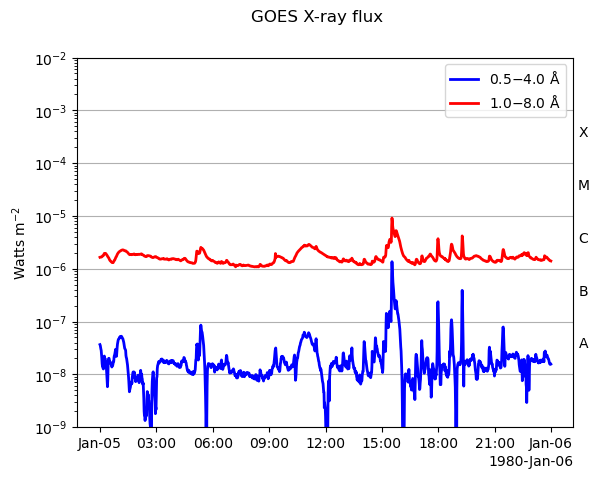

Se encontraron datos  GOES para 1980-01-05 00:00:00 - 1980-01-05 23:59:00. Día saltado.

Número de registros: 1440
Columnas disponibles: ['xrsa', 'xrsb']
2. Restar Background


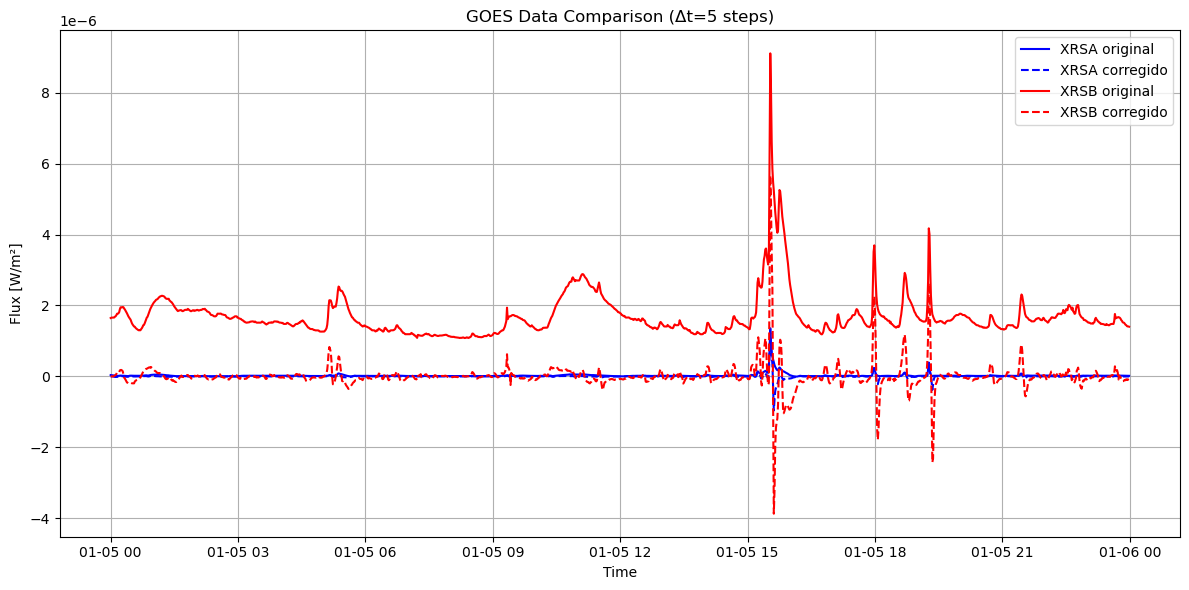

3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1980-01-05 00:00:00
End Date:			1980-01-05 23:59:00
Center Date:			1980-01-05 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.35E+01<br>emission_measure   1.23E+50
Units:			1 / cm3<br>MK
                     temperature  emission_measure
1980-01-05 00:00:00     2.682203      0.000000e+00
1980-01-05 00:01:00     2.682203      0.000000e+00
1980-01-05 00:02:00     2.682203      0.000000e+00
1980-01-05 00:03:00     2.682203      0.000000e+00
1980-01-05 00:04:00     2.682203      0.000000e+00
...                          ...               ...
1980-01-05 23:55:00     2.682203     -2.177679e+48
1980-01-05 23:56:00     2.682203     -2.755114e+48
1980-01-05 23:57:00     2.682203     -2.796544e+48
1980-01-05 23:58:00     2.682203     -2.066337e+48
1980-01-05

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1980-01-05 00:00:00
End Date:			1980-01-05 23:59:00
Center Date:			1980-01-05 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.34E+01<br>emission_measure   3.82E+50
Units:			1 / cm3<br>MK
                     temperature  emission_measure
1980-01-05 00:00:00     2.548023      0.000000e+00
1980-01-05 00:01:00     2.548023      0.000000e+00
1980-01-05 00:02:00     2.548023      0.000000e+00
1980-01-05 00:03:00     2.548023      0.000000e+00
1980-01-05 00:04:00     2.548023      0.000000e+00
...                          ...               ...
1980-01-05 23:55:00     2.548023     -6.773700e+48
1980-01-05 23:56:00     2.548023     -8.569818e+48
1980-01-05 23:57:00     2.548023     -8.698687e+48
1980-01-05 23:58:00     2.548023     -6.427368e+48
1980-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.37file/s]


Cargando datos de 1983-04-09 00:00:00 en un TimeSeries:


2025-09-15 17:03:01 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-15 17:03:01 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1983-04-09 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-2
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1983-04-09 00:00:00
End Date:			1983-04-09 23:59:00
Center Date:			1983-04-09 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   6.38E-05<br>xrsb   6.30E-04
Units:			dimensionless
                             xrsa          xrsb
1983-04-09 00:00:00  4.461737e-08  1.076826e-06
1983-04-09 00:01:00  3.297900e-08  1.154850e-06
1983-04-09 00:02:00  3.611074e-08  1.119211e-06
1983-04-09 00:03:00  2.746850e-08  1.080200e-06
1983-04-09 00:04:00  2.976100e-08  1.038150e-06
...                           ...           ...
1983-04-09 23:55:00  4.979421e-09  2.740474e-07
1983-04-09 23:56:00  4.911550e-09  2

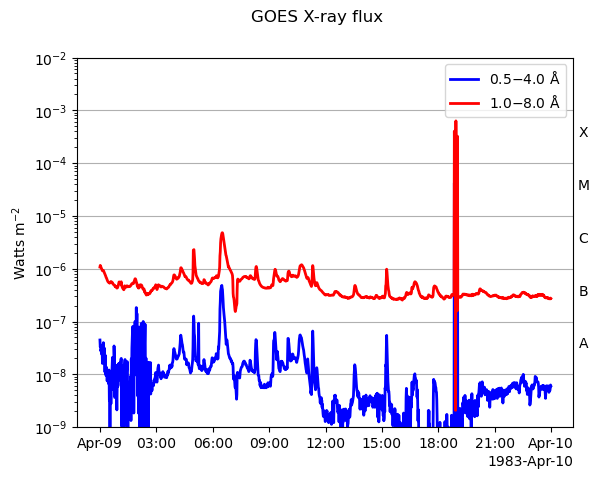

Se encontraron datos  GOES para 1983-04-09 00:00:00 - 1983-04-09 23:59:00. Día saltado.

Número de registros: 1440
Columnas disponibles: ['xrsa', 'xrsb']
2. Restar Background


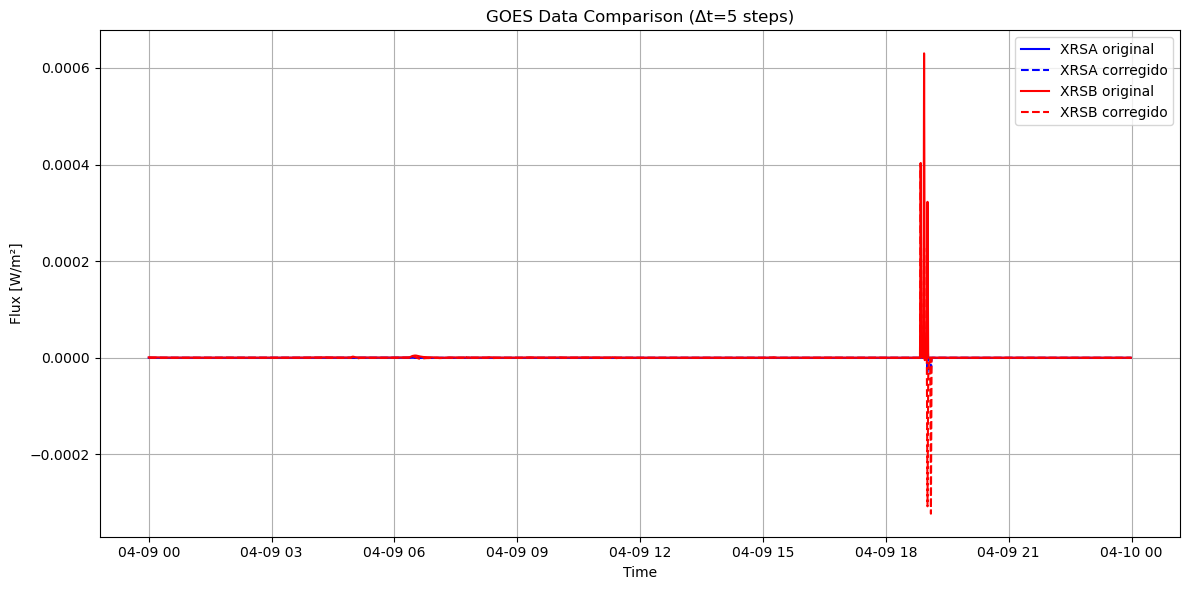

3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1983-04-09 00:00:00
End Date:			1983-04-09 23:59:00
Center Date:			1983-04-09 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        7.60E+03<br>emission_measure   9.00E+51
Units:			1 / cm3<br>MK
                     temperature  emission_measure
1983-04-09 00:00:00     2.682203      0.000000e+00
1983-04-09 00:01:00     2.682203      0.000000e+00
1983-04-09 00:02:00     2.682203      0.000000e+00
1983-04-09 00:03:00     2.682203      0.000000e+00
1983-04-09 00:04:00     2.682203      0.000000e+00
...                          ...               ...
1983-04-09 23:55:00     2.682203     -4.718501e+46
1983-04-09 23:56:00     2.682203     -1.754748e+47
1983-04-09 23:57:00     2.682203     -1.551978e+47
1983-04-09 23:58:00     2.682203      2.284923e+47
1983-04-09

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1983-04-09 00:00:00
End Date:			1983-04-09 23:59:00
Center Date:			1983-04-09 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        3.59E+03<br>emission_measure   2.79E+52
Units:			1 / cm3<br>MK
                     temperature  emission_measure
1983-04-09 00:00:00     2.548023      0.000000e+00
1983-04-09 00:01:00     2.548023      0.000000e+00
1983-04-09 00:02:00     2.548023      0.000000e+00
1983-04-09 00:03:00     2.548023      0.000000e+00
1983-04-09 00:04:00     2.548023      0.000000e+00
...                          ...               ...
1983-04-09 23:55:00     2.548023     -1.467696e+47
1983-04-09 23:56:00     2.548023     -5.458167e+47
1983-04-09 23:57:00     2.548023     -4.827449e+47
1983-04-09 23:58:00     2.548023      7.107283e+47
1983-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.38file/s]


Cargando datos de 1986-07-12 00:00:00 en un TimeSeries:


2025-09-15 17:03:12 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-15 17:03:12 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1986-07-12 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1986-07-12 00:00:00
End Date:			1986-07-12 23:59:00
Center Date:			1986-07-12 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   2.87E-08<br>xrsb   4.87E-07
Units:			dimensionless
                             xrsa          xrsb
1986-07-12 00:00:00  1.000000e-09  4.202500e-08
1986-07-12 00:01:00  1.000000e-09  4.059000e-08
1986-07-12 00:02:00  1.000000e-09  4.084211e-08
1986-07-12 00:03:00  1.000000e-09  4.109500e-08
1986-07-12 00:04:00  1.000000e-09  3.989375e-08
...                           ...           ...
1986-07-12 23:55:00  1.000000e-09  5.923000e-08
1986-07-12 23:56:00  1.000000e-09  5

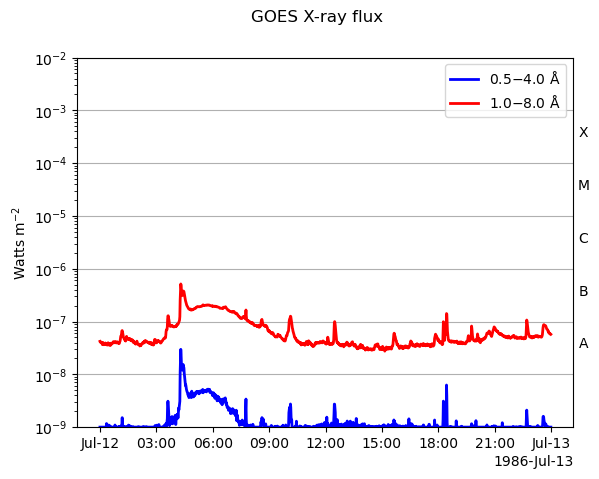

Se encontraron datos  GOES para 1986-07-12 00:00:00 - 1986-07-12 23:59:00. Día saltado.

Número de registros: 1440
Columnas disponibles: ['xrsa', 'xrsb']
2. Restar Background


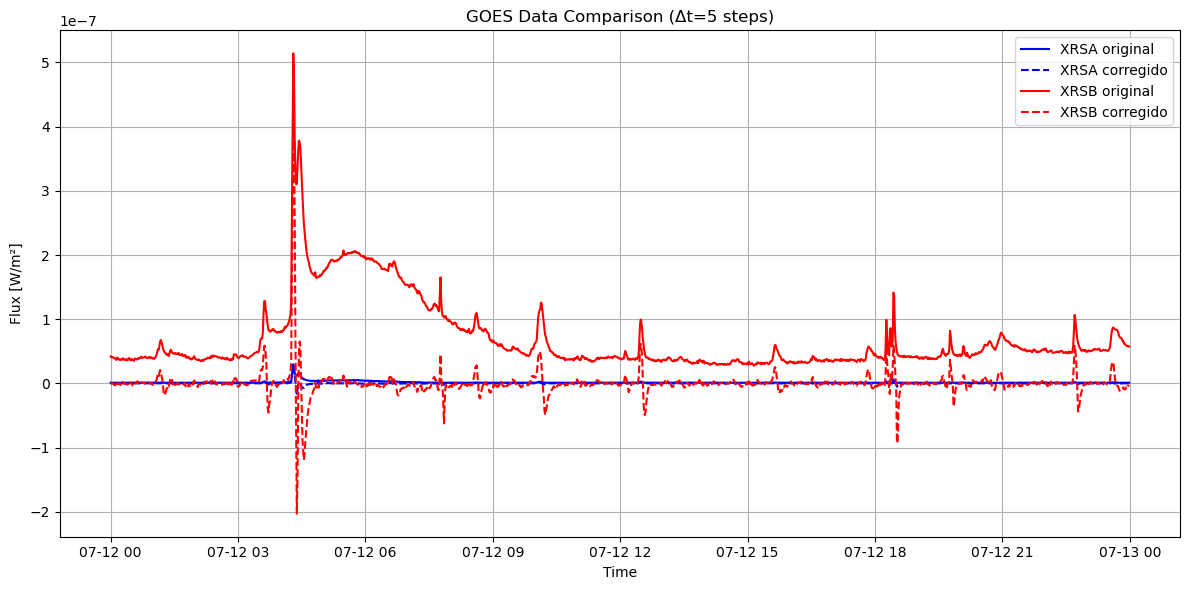

3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.18file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1986-07-12 00:00:00
End Date:			1986-07-12 23:59:00
Center Date:			1986-07-12 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        6.66E+00<br>emission_measure   4.81E+48
Units:			1 / cm3<br>MK
                     temperature  emission_measure
1986-07-12 00:00:00     2.978802      0.000000e+00
1986-07-12 00:01:00     2.978802      0.000000e+00
1986-07-12 00:02:00     2.978802      0.000000e+00
1986-07-12 00:03:00     2.978802      0.000000e+00
1986-07-12 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1986-07-12 23:55:00     2.978802     -1.251156e+47
1986-07-12 23:56:00     2.978802     -1.532666e+47
1986-07-12 23:57:00     2.978802     -7.037760e+46
1986-07-12 23:58:00     2.978802     -7.562134e+46
1986-07-12

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.03file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1986-07-12 00:00:00
End Date:			1986-07-12 23:59:00
Center Date:			1986-07-12 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        5.75E+00<br>emission_measure   1.66E+49
Units:			1 / cm3<br>MK
                     temperature  emission_measure
1986-07-12 00:00:00     2.763595      0.000000e+00
1986-07-12 00:01:00     2.763595      0.000000e+00
1986-07-12 00:02:00     2.763595      0.000000e+00
1986-07-12 00:03:00     2.763595      0.000000e+00
1986-07-12 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1986-07-12 23:55:00     2.763595     -4.315378e+47
1986-07-12 23:56:00     2.763595     -5.286336e+47
1986-07-12 23:57:00     2.763595     -2.427402e+47
1986-07-12 23:58:00     2.763595     -2.608265e+47
1986-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.37file/s]


Cargando datos de 1989-10-14 00:00:00 en un TimeSeries:


2025-09-15 17:03:23 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-15 17:03:23 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1989-10-14 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1989-10-14 00:00:00
End Date:			1989-10-14 23:59:00
Center Date:			1989-10-14 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   1.22E-05<br>xrsb   1.43E-04
Units:			dimensionless
                             xrsa      xrsb
1989-10-14 00:00:00  6.026500e-08  0.000002
1989-10-14 00:01:00  5.648000e-08  0.000002
1989-10-14 00:02:00  5.467895e-08  0.000002
1989-10-14 00:03:00  5.232500e-08  0.000002
1989-10-14 00:04:00  5.622000e-08  0.000002
...                           ...       ...
1989-10-14 23:55:00  7.523000e-07  0.000008
1989-10-14 23:56:00  7.618948e-07  0.000008
1989-10-14 23:57:00  7.7

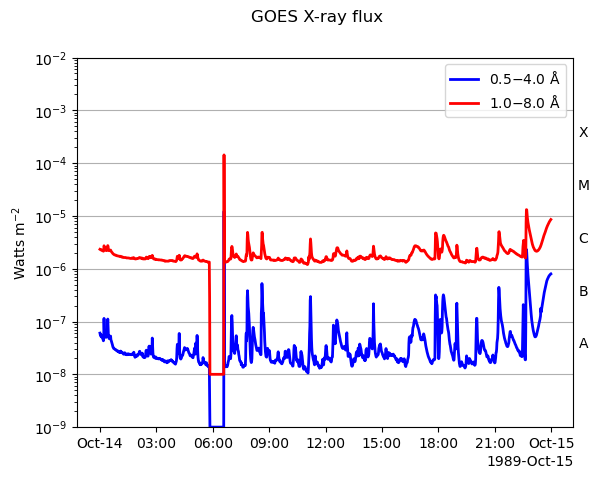

Se encontraron datos  GOES para 1989-10-14 00:00:00 - 1989-10-14 23:59:00. Día saltado.

Número de registros: 1440
Columnas disponibles: ['xrsa', 'xrsb']
2. Restar Background


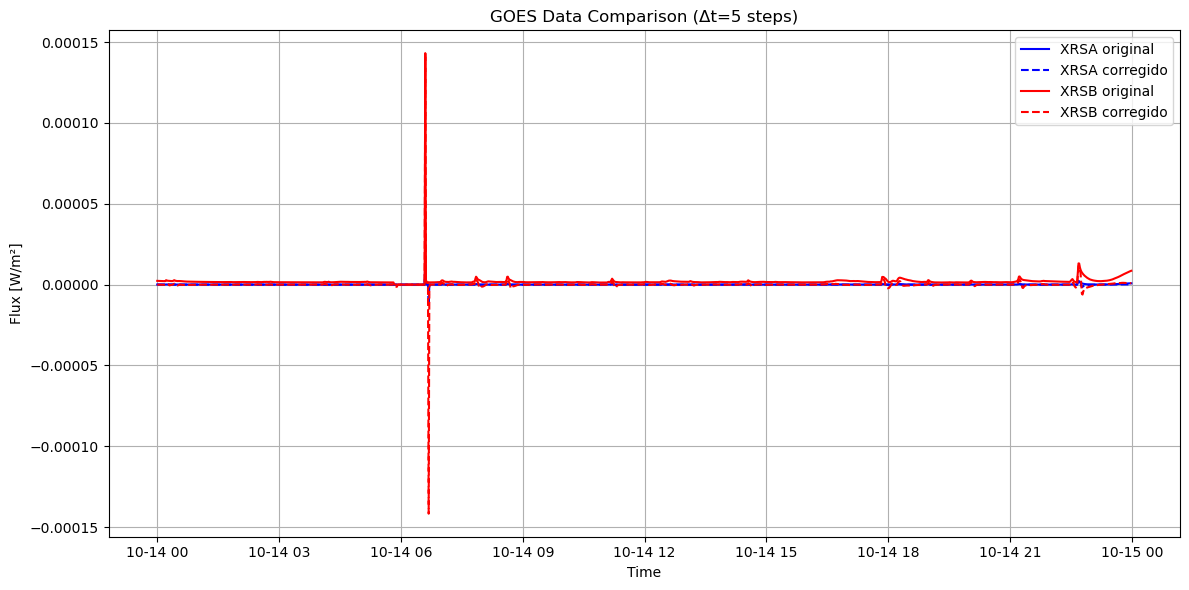

3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.05file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1989-10-14 00:00:00
End Date:			1989-10-14 23:59:00
Center Date:			1989-10-14 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        4.49E+01<br>emission_measure   2.94E+51
Units:			1 / cm3<br>MK
                     temperature  emission_measure
1989-10-14 00:00:00     2.978802      0.000000e+00
1989-10-14 00:01:00     2.978802      0.000000e+00
1989-10-14 00:02:00     2.978802      0.000000e+00
1989-10-14 00:03:00     2.978802      0.000000e+00
1989-10-14 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1989-10-14 23:55:00    10.758827      5.854085e+47
1989-10-14 23:56:00    10.225194      5.921101e+47
1989-10-14 23:57:00    10.080941      6.194386e+47
1989-10-14 23:58:00     9.861291      6.183520e+47
1989-10-14

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7fd1a0617420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.16file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1989-10-14 00:00:00
End Date:			1989-10-14 23:59:00
Center Date:			1989-10-14 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        6.66E+01<br>emission_measure   1.01E+52
Units:			1 / cm3<br>MK
                     temperature  emission_measure
1989-10-14 00:00:00     2.763595      0.000000e+00
1989-10-14 00:01:00     2.763595      0.000000e+00
1989-10-14 00:02:00     2.763595      0.000000e+00
1989-10-14 00:03:00     2.763595      0.000000e+00
1989-10-14 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1989-10-14 23:55:00     9.623375      1.620665e+48
1989-10-14 23:56:00     9.083679      1.697236e+48
1989-10-14 23:57:00     8.940999      1.792166e+48
1989-10-14 23:58:00     8.726348      1.814200e+48
1989-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.38file/s]


Cargando datos de 1993-01-16 00:00:00 en un TimeSeries:


2025-09-15 17:03:35 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-15 17:03:35 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1993-01-16 00:00:00 tengan resolución de un min
Resolution detected: 3.06 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1993-01-16 00:00:00
End Date:			1993-01-16 23:59:00
Center Date:			1993-01-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   3.71E-07<br>xrsb   3.95E-06
Units:			dimensionless
                             xrsa          xrsb
1993-01-16 00:00:00  5.439030e-09  4.993984e-07
1993-01-16 00:01:00  5.720806e-09  5.190209e-07
1993-01-16 00:02:00  5.116685e-09  5.104141e-07
1993-01-16 00:03:00  4.348811e-09  4.917471e-07
1993-01-16 00:04:00  2.831075e-09  4.713164e-07
...                           ...           ...
1993-01-16 23:55:00  7.471205e-09  6.273972e-07
1993-01-16 23:56:00  6.930521e-09  6

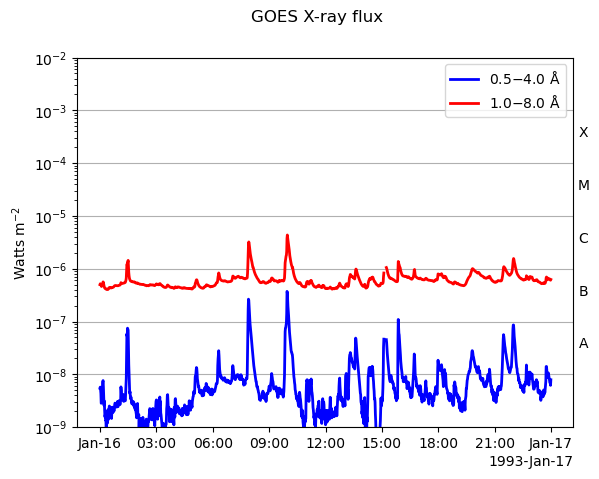

Se encontraron datos  GOES para 1993-01-16 00:00:00 - 1993-01-16 23:59:00. Día saltado.

Número de registros: 1440
Columnas disponibles: ['xrsa', 'xrsb']
2. Restar Background


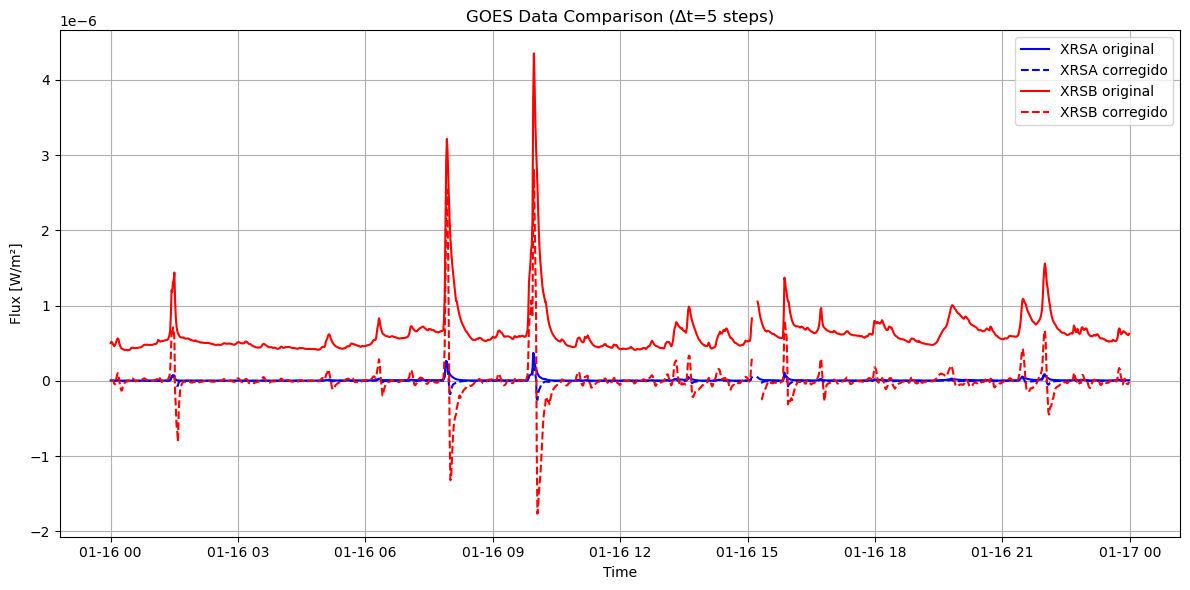

3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1993-01-16 00:00:00
End Date:			1993-01-16 23:59:00
Center Date:			1993-01-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.15E+01<br>emission_measure   4.37E+49
Units:			1 / cm3<br>MK
                     temperature  emission_measure
1993-01-16 00:00:00     2.978802      0.000000e+00
1993-01-16 00:01:00     2.978802      0.000000e+00
1993-01-16 00:02:00     2.978802      0.000000e+00
1993-01-16 00:03:00     2.978802      0.000000e+00
1993-01-16 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1993-01-16 23:55:00     2.978802     -4.258045e+47
1993-01-16 23:56:00     2.978802     -8.404031e+47
1993-01-16 23:57:00     2.978802     -8.829179e+47
1993-01-16 23:58:00     2.978802     -7.942646e+47
1993-01-16

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1993-01-16 00:00:00
End Date:			1993-01-16 23:59:00
Center Date:			1993-01-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.11E+01<br>emission_measure   1.51E+50
Units:			1 / cm3<br>MK
                     temperature  emission_measure
1993-01-16 00:00:00     2.763595      0.000000e+00
1993-01-16 00:01:00     2.763595      0.000000e+00
1993-01-16 00:02:00     2.763595      0.000000e+00
1993-01-16 00:03:00     2.763595      0.000000e+00
1993-01-16 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1993-01-16 23:55:00     2.763595     -1.468648e+48
1993-01-16 23:56:00     2.763595     -2.898644e+48
1993-01-16 23:57:00     2.763595     -3.045283e+48
1993-01-16 23:58:00     2.763595     -2.739508e+48
1993-

Files Downloaded: 100%|██████████| 3/3 [00:00<00:00,  5.23file/s]


Cargando datos de 1996-04-20 00:00:00 en un TimeSeries:


2025-09-15 17:03:49 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-15 17:03:49 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1996-04-20 00:00:00 tengan resolución de un min
Resolution detected: 3.05 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-7
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1996-04-20 00:00:00
End Date:			1996-04-20 23:59:00
Center Date:			1996-04-20 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   1.37E-08<br>xrsb   2.92E-07
Units:			dimensionless
                             xrsa          xrsb
1996-04-20 00:00:00  2.760896e-10  4.046270e-09
1996-04-20 00:01:00  2.685701e-10  1.916653e-09
1996-04-20 00:02:00  5.221351e-10  4.507407e-09
1996-04-20 00:03:00  3.124211e-10  4.860587e-09
1996-04-20 00:04:00  6.973752e-10  4.471508e-09
...                           ...           ...
1996-04-20 23:55:00  5.534652e-10  3.095131e-08
1996-04-20 23:56:00  6.190502e-10  3

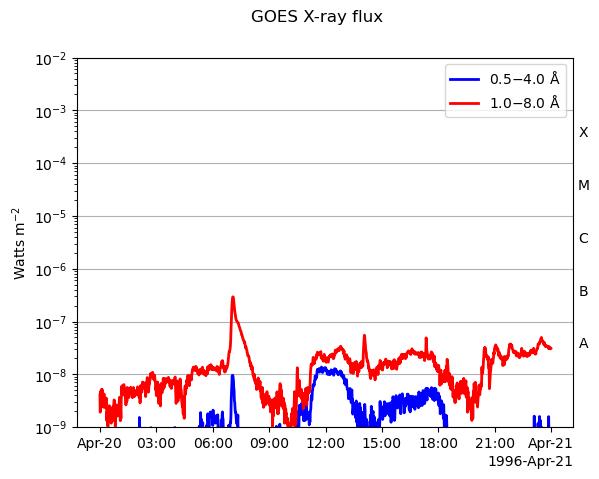

Se encontraron datos  GOES para 1996-04-20 00:00:00 - 1996-04-20 23:59:00. Día saltado.

Número de registros: 1440
Columnas disponibles: ['xrsa', 'xrsb']
2. Restar Background


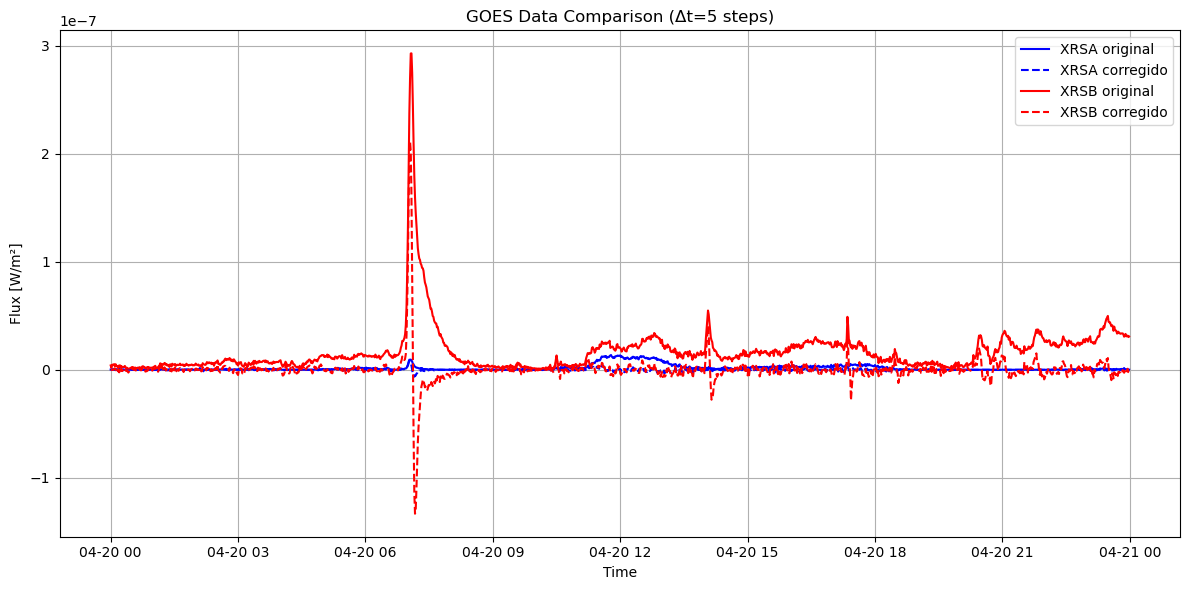

3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1996-04-20 00:00:00
End Date:			1996-04-20 23:59:00
Center Date:			1996-04-20 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        8.29E+00<br>emission_measure   4.06E+48
Units:			1 / cm3<br>MK
                     temperature  emission_measure
1996-04-20 00:00:00     2.999061      0.000000e+00
1996-04-20 00:01:00     2.999061      0.000000e+00
1996-04-20 00:02:00     2.999061      0.000000e+00
1996-04-20 00:03:00     2.999061      0.000000e+00
1996-04-20 00:04:00     2.999061      0.000000e+00
...                          ...               ...
1996-04-20 23:55:00     2.999061     -5.083996e+46
1996-04-20 23:56:00     2.999061     -2.392465e+46
1996-04-20 23:57:00     2.999061      1.888780e+46
1996-04-20 23:58:00     2.999061     -3.588704e+46
1996-04-20

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1996-04-20 00:00:00
End Date:			1996-04-20 23:59:00
Center Date:			1996-04-20 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        7.44E+00<br>emission_measure   1.43E+49
Units:			1 / cm3<br>MK
                     temperature  emission_measure
1996-04-20 00:00:00     2.774622      0.000000e+00
1996-04-20 00:01:00     2.774622      0.000000e+00
1996-04-20 00:02:00     2.774622      0.000000e+00
1996-04-20 00:03:00     2.774622      0.000000e+00
1996-04-20 00:04:00     2.774622      0.000000e+00
...                          ...               ...
1996-04-20 23:55:00     2.774622     -1.789170e+47
1996-04-20 23:56:00     2.774622     -8.419611e+46
1996-04-20 23:57:00     2.774622      6.647032e+46
1996-04-20 23:58:00     2.774622     -1.262944e+47
1996-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  4.71file/s]


Cargando datos de 1999-07-24 00:00:00 en un TimeSeries:


2025-09-15 17:04:01 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-15 17:04:01 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1999-07-24 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-8
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1999-07-24 00:00:00
End Date:			1999-07-24 23:59:00
Center Date:			1999-07-24 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   5.17E-06<br>xrsb   3.25E-05
Units:			dimensionless
                             xrsa      xrsb
1999-07-24 00:00:00  7.916543e-08  0.000003
1999-07-24 00:01:00  7.536231e-08  0.000003
1999-07-24 00:02:00  7.190549e-08  0.000003
1999-07-24 00:03:00  6.947787e-08  0.000003
1999-07-24 00:04:00  6.722927e-08  0.000003
...                           ...       ...
1999-07-24 23:55:00  3.741601e-08  0.000002
1999-07-24 23:56:00  3.788496e-08  0.000002
1999-07-24 23:57:00  3.8

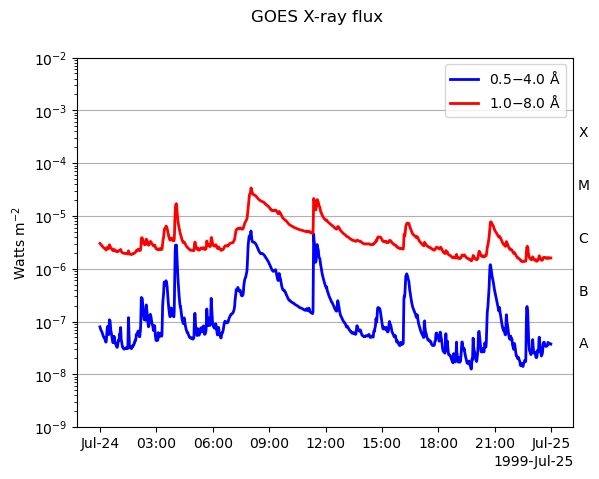

Se encontraron datos  GOES para 1999-07-24 00:00:00 - 1999-07-24 23:59:00. Día saltado.

Número de registros: 1440
Columnas disponibles: ['xrsa', 'xrsb']
2. Restar Background


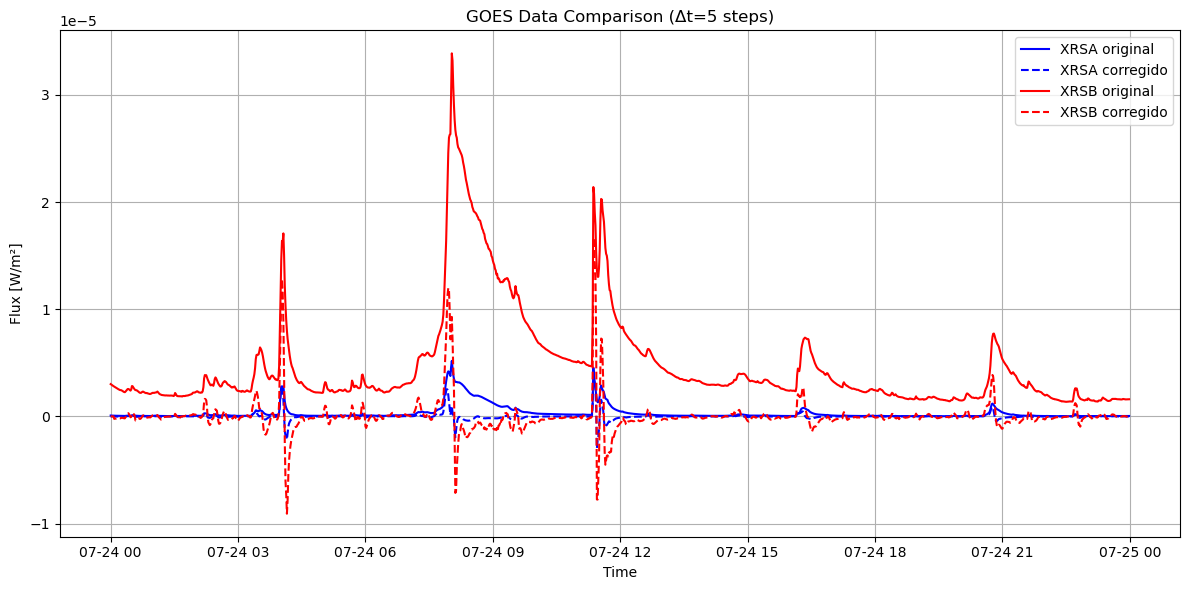

3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.03file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1999-07-24 00:00:00
End Date:			1999-07-24 23:59:00
Center Date:			1999-07-24 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        5.46E+01<br>emission_measure   2.46E+50
Units:			1 / cm3<br>MK
                     temperature  emission_measure
1999-07-24 00:00:00     3.269362      0.000000e+00
1999-07-24 00:01:00     3.269362      0.000000e+00
1999-07-24 00:02:00     3.269362      0.000000e+00
1999-07-24 00:03:00     3.269362      0.000000e+00
1999-07-24 00:04:00     3.269362      0.000000e+00
...                          ...               ...
1999-07-24 23:55:00     3.269362     -4.303805e+47
1999-07-24 23:56:00     3.269362     -5.964146e+47
1999-07-24 23:57:00     3.269362     -1.122717e+47
1999-07-24 23:58:00     3.269362     -1.510506e+47
1999-07-24

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7fd1a0617420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1999-07-24 00:00:00
End Date:			1999-07-24 23:59:00
Center Date:			1999-07-24 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        8.49E+01<br>emission_measure   8.52E+50
Units:			1 / cm3<br>MK
                     temperature  emission_measure
1999-07-24 00:00:00     2.993372      0.000000e+00
1999-07-24 00:01:00     2.993372      0.000000e+00
1999-07-24 00:02:00     2.993372      0.000000e+00
1999-07-24 00:03:00     2.993372      0.000000e+00
1999-07-24 00:04:00     2.993372      0.000000e+00
...                          ...               ...
1999-07-24 23:55:00     2.993372     -1.545088e+48
1999-07-24 23:56:00     2.993372     -2.141159e+48
1999-07-24 23:57:00     2.993372     -4.030612e+47
1999-07-24 23:58:00     2.993372     -5.422793e+47
1999-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.80file/s]


Cargando datos de 2002-10-26 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2002-10-26 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2002-10-26 00:00:00
End Date:			2002-10-26 23:59:00
Center Date:			2002-10-26 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           2.90E-07<br>xrsb           3.40E-06<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2002-10-26 00:00:00  5.104403e-08  1.977271e-06             0             0
2002-10-26 00:01:00  4.954107e-08  1.919137e-06             0             0
2002-10-26 00:02:00  4.933372e-08  1.917279e-06           

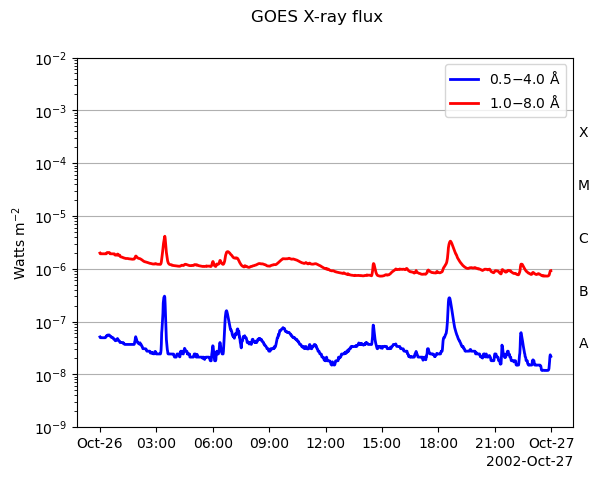

Se encontraron datos  GOES para 2002-10-26 00:00:00 - 2002-10-26 23:59:00. Día saltado.

Número de registros: 1440
Columnas disponibles: ['xrsa', 'xrsb', 'xrsa_quality', 'xrsb_quality']
2. Restar Background


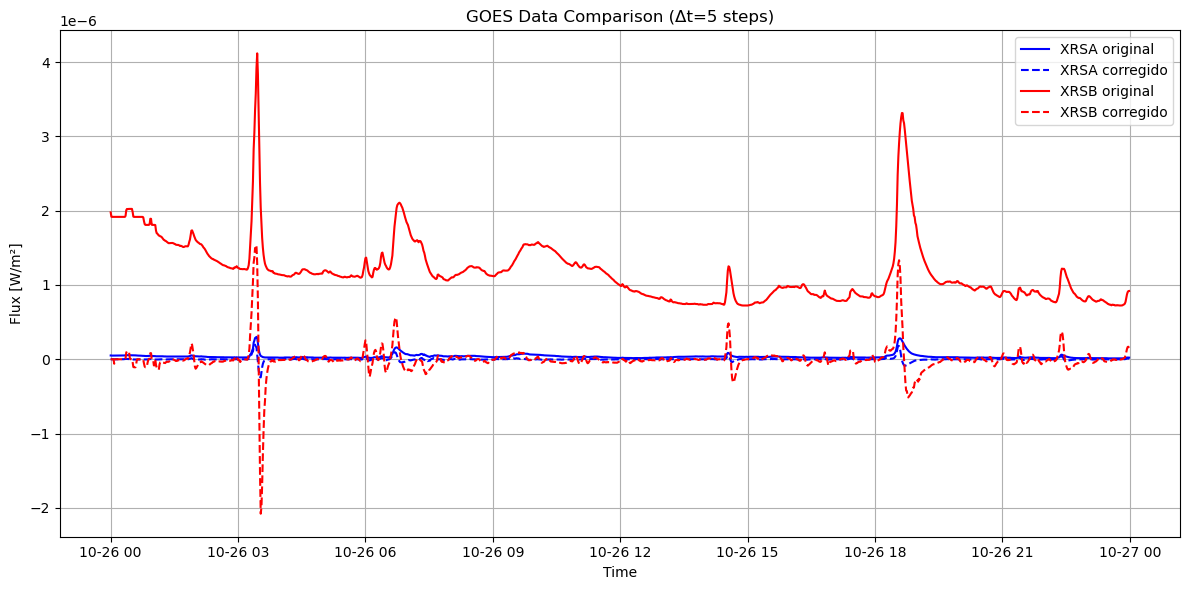

3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2002-10-26 00:00:00
End Date:			2002-10-26 23:59:00
Center Date:			2002-10-26 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.07E+01<br>emission_measure   7.18E+49
Units:			1 / cm3<br>MK
                     temperature  emission_measure
2002-10-26 00:00:00     2.795147      0.000000e+00
2002-10-26 00:01:00     2.795147      0.000000e+00
2002-10-26 00:02:00     2.795147      0.000000e+00
2002-10-26 00:03:00     2.795147      0.000000e+00
2002-10-26 00:04:00     2.795147      0.000000e+00
...                          ...               ...
2002-10-26 23:55:00     9.893942      5.237094e+46
2002-10-26 23:56:00    10.484754      7.249329e+46
2002-10-26 23:57:00    10.265777      8.969626e+46
2002-10-26 23:58:00     9.587872      1.006423e+47
2002-10-26

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7fd1a0617420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.12file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2002-10-26 00:00:00
End Date:			2002-10-26 23:59:00
Center Date:			2002-10-26 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.35E+01<br>emission_measure   2.27E+50
Units:			1 / cm3<br>MK
                     temperature  emission_measure
2002-10-26 00:00:00     2.645967      0.000000e+00
2002-10-26 00:01:00     2.645967      0.000000e+00
2002-10-26 00:02:00     2.645967      0.000000e+00
2002-10-26 00:03:00     2.645967      0.000000e+00
2002-10-26 00:04:00     2.645967      0.000000e+00
...                          ...               ...
2002-10-26 23:55:00     8.799988      1.516237e+47
2002-10-26 23:56:00     9.388759      2.020456e+47
2002-10-26 23:57:00     9.167865      2.535741e+47
2002-10-26 23:58:00     8.503245      2.970515e+47
2002-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  3.59file/s]


Cargando datos de 2006-01-28 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2006-01-28 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2006-01-28 00:00:00
End Date:			2006-01-28 23:59:00
Center Date:			2006-01-28 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           2.44E-08<br>xrsb           4.27E-07<br>xrsa_quality   4.00E+00<br>xrsb_quality   4.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2006-01-28 00:00:00  1.204239e-08  9.696457e-08             0             0
2006-01-28 00:01:00  1.204362e-08  1.025506e-07             0             0
2006-01-28 00:02:00  1.204173e-08  1.025370e-07           

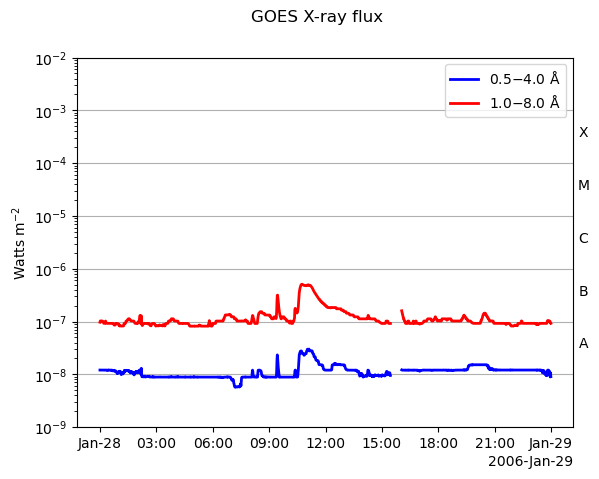

Se encontraron datos  GOES para 2006-01-28 00:00:00 - 2006-01-28 23:59:00. Día saltado.

Número de registros: 1440
Columnas disponibles: ['xrsa', 'xrsb', 'xrsa_quality', 'xrsb_quality']
2. Restar Background


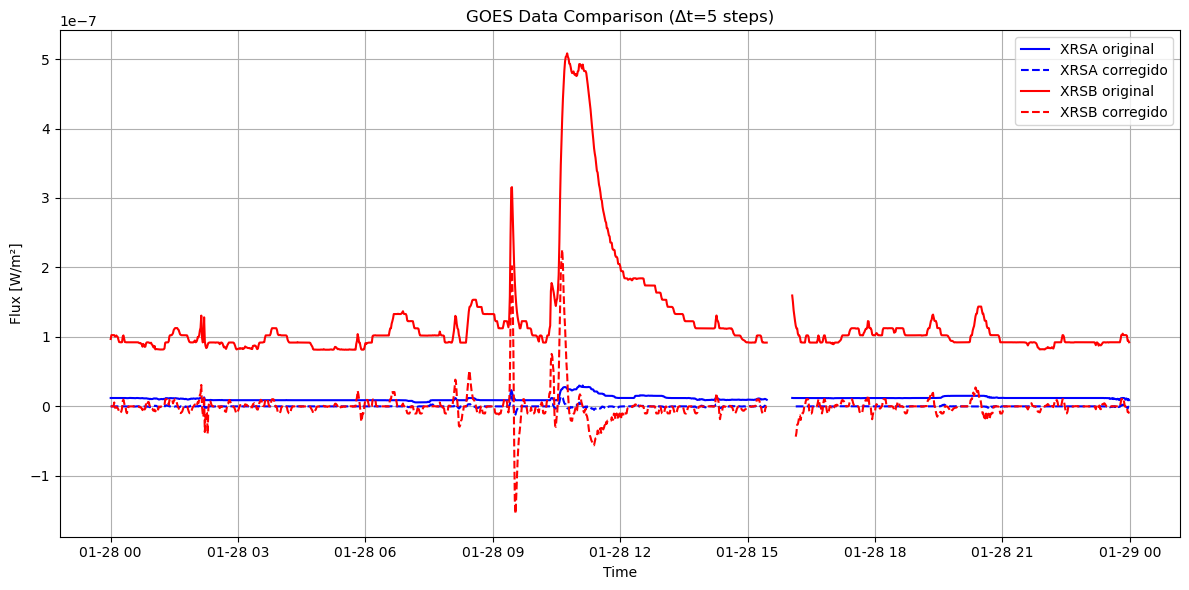

3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2006-01-28 00:00:00
End Date:			2006-01-28 23:59:00
Center Date:			2006-01-28 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        8.59E+00<br>emission_measure   5.42E+48
Units:			1 / cm3<br>MK
                     temperature  emission_measure
2006-01-28 00:00:00     2.795147      0.000000e+00
2006-01-28 00:01:00     2.795147      0.000000e+00
2006-01-28 00:02:00     2.795147      0.000000e+00
2006-01-28 00:03:00     2.795147      0.000000e+00
2006-01-28 00:04:00     2.795147      0.000000e+00
...                          ...               ...
2006-01-28 23:55:00     2.795147     -5.278543e+46
2006-01-28 23:56:00     2.795147     -2.619259e+46
2006-01-28 23:57:00     2.795147     -2.037397e+47
2006-01-28 23:58:00     2.795147     -2.008669e+47
2006-01-28

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2006-01-28 00:00:00
End Date:			2006-01-28 23:59:00
Center Date:			2006-01-28 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        7.68E+00<br>emission_measure   1.71E+49
Units:			1 / cm3<br>MK
                     temperature  emission_measure
2006-01-28 00:00:00     2.645967      0.000000e+00
2006-01-28 00:01:00     2.645967      0.000000e+00
2006-01-28 00:02:00     2.645967      0.000000e+00
2006-01-28 00:03:00     2.645967      0.000000e+00
2006-01-28 00:04:00     2.645967      0.000000e+00
...                          ...               ...
2006-01-28 23:55:00     2.645967     -1.667735e+47
2006-01-28 23:56:00     2.645967     -8.275445e+46
2006-01-28 23:57:00     2.645967     -6.437077e+47
2006-01-28 23:58:00     2.645967     -6.346310e+47
2006-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.83file/s]


Cargando datos de 2009-05-02 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2009-05-02 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2009-05-02 00:00:00
End Date:			2009-05-02 23:59:00
Center Date:			2009-05-02 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           6.40E-09<br>xrsb           9.20E-08<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2009-05-02 00:00:00  6.099223e-09  5.322857e-09             0             0
2009-05-02 00:01:00  6.072129e-09  5.322857e-09             0             0
2009-05-02 00:02:00  6.131999e-09  5.322857e-09           

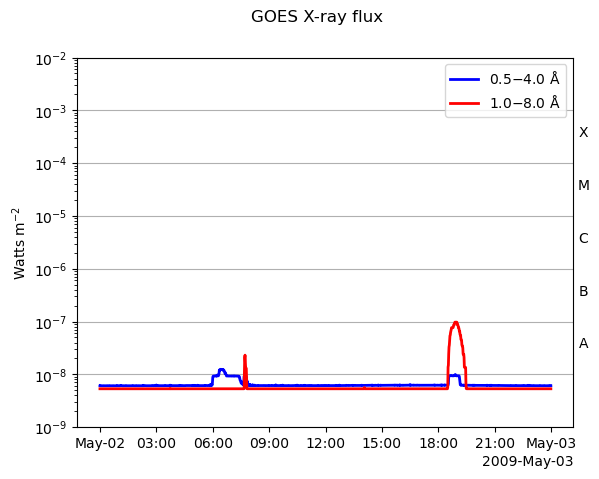

Se encontraron datos  GOES para 2009-05-02 00:00:00 - 2009-05-02 23:59:00. Día saltado.

Número de registros: 1440
Columnas disponibles: ['xrsa', 'xrsb', 'xrsa_quality', 'xrsb_quality']
2. Restar Background


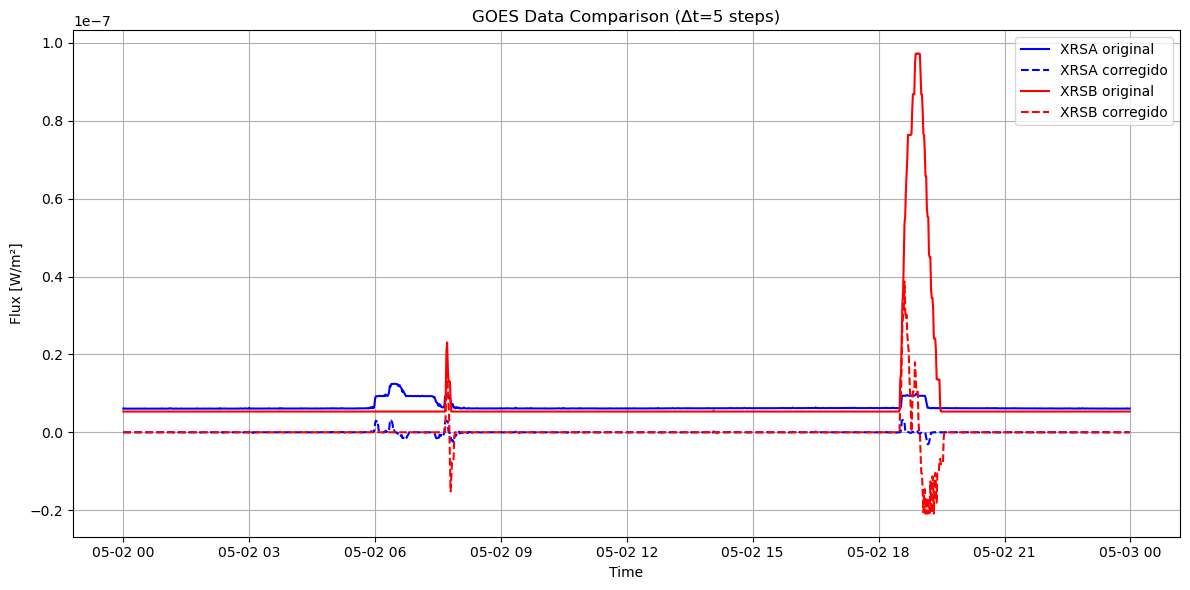

3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2009-05-02 00:00:00
End Date:			2009-05-02 23:59:00
Center Date:			2009-05-02 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        9.77E+00<br>emission_measure   1.25E+48
Units:			1 / cm3<br>MK
                     temperature  emission_measure
2009-05-02 00:00:00     2.795147               0.0
2009-05-02 00:01:00     2.795147               0.0
2009-05-02 00:02:00     2.795147               0.0
2009-05-02 00:03:00     2.795147               0.0
2009-05-02 00:04:00     2.795147               0.0
...                          ...               ...
2009-05-02 23:55:00     2.795147               0.0
2009-05-02 23:56:00     2.795147               0.0
2009-05-02 23:57:00     2.795147               0.0
2009-05-02 23:58:00     2.795147               0.0
2009-05-02

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2009-05-02 00:00:00
End Date:			2009-05-02 23:59:00
Center Date:			2009-05-02 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        9.02E+00<br>emission_measure   3.96E+48
Units:			1 / cm3<br>MK
                     temperature  emission_measure
2009-05-02 00:00:00     2.645967               0.0
2009-05-02 00:01:00     2.645967               0.0
2009-05-02 00:02:00     2.645967               0.0
2009-05-02 00:03:00     2.645967               0.0
2009-05-02 00:04:00     2.645967               0.0
...                          ...               ...
2009-05-02 23:55:00     2.645967               0.0
2009-05-02 23:56:00     2.645967               0.0
2009-05-02 23:57:00     2.645967               0.0
2009-05-02 23:58:00     2.645967               0.0
2009-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.62file/s]


Cargando datos de 2012-08-04 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2012-08-04 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-15
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2012-08-04 00:00:00
End Date:			2012-08-04 23:59:00
Center Date:			2012-08-04 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           2.45E-07<br>xrsb           4.35E-06<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2012-08-04 00:00:00  5.027052e-09  7.878079e-07             0             0
2012-08-04 00:01:00  3.409986e-09  7.800567e-07             0             0
2012-08-04 00:02:00  1.000000e-09  7.786075e-07           

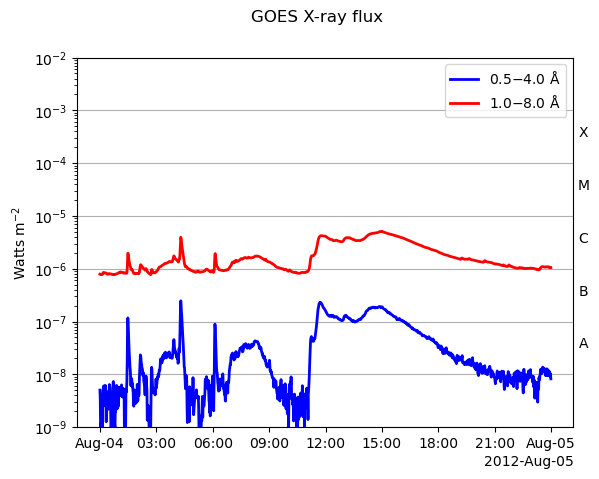

Se encontraron datos  GOES para 2012-08-04 00:00:00 - 2012-08-04 23:59:00. Día saltado.

Número de registros: 1440
Columnas disponibles: ['xrsa', 'xrsb', 'xrsa_quality', 'xrsb_quality']
2. Restar Background


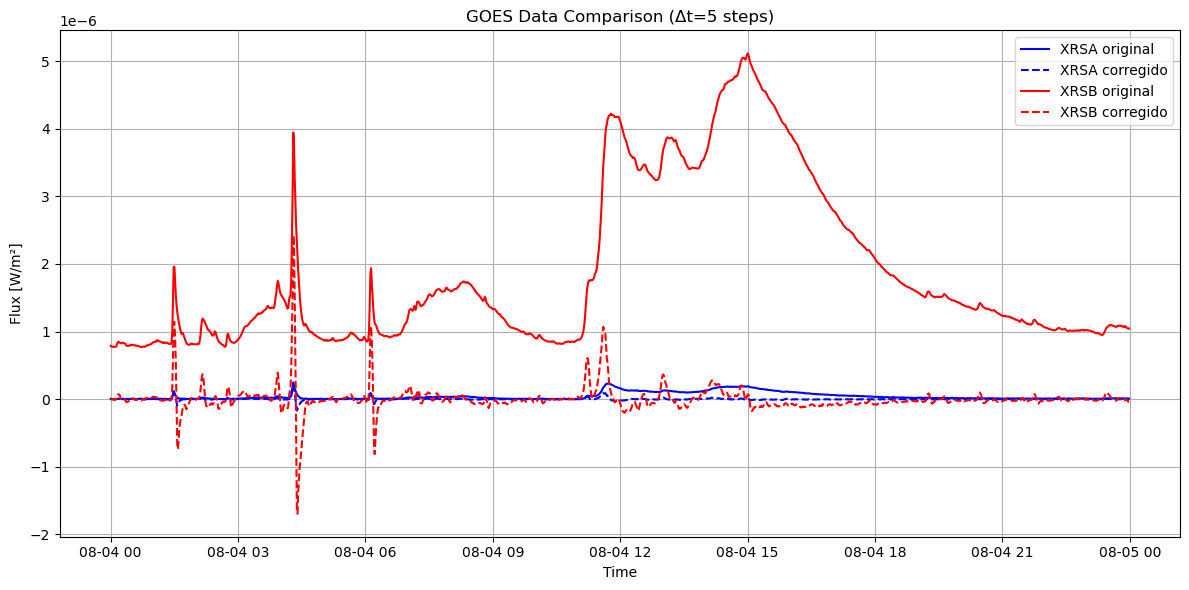

3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2012-08-04 00:00:00
End Date:			2012-08-04 23:59:00
Center Date:			2012-08-04 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.33E+01<br>emission_measure   4.40E+49
Units:			1 / cm3<br>MK
                     temperature  emission_measure
2012-08-04 00:00:00     2.750396      0.000000e+00
2012-08-04 00:01:00     2.750396      0.000000e+00
2012-08-04 00:02:00     2.750396      0.000000e+00
2012-08-04 00:03:00     2.750396      0.000000e+00
2012-08-04 00:04:00     2.750396      0.000000e+00
...                          ...               ...
2012-08-04 23:55:00     2.750396     -2.101378e+47
2012-08-04 23:56:00     2.750396     -5.258473e+47
2012-08-04 23:57:00     2.750396     -4.781357e+47
2012-08-04 23:58:00     2.750396     -8.894740e+47
2012-08-04

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2012-08-04 00:00:00
End Date:			2012-08-04 23:59:00
Center Date:			2012-08-04 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.31E+01<br>emission_measure   1.38E+50
Units:			1 / cm3<br>MK
                     temperature  emission_measure
2012-08-04 00:00:00     2.605354      0.000000e+00
2012-08-04 00:01:00     2.605354      0.000000e+00
2012-08-04 00:02:00     2.605354      0.000000e+00
2012-08-04 00:03:00     2.605354      0.000000e+00
2012-08-04 00:04:00     2.605354      0.000000e+00
...                          ...               ...
2012-08-04 23:55:00     2.605354     -6.574193e+47
2012-08-04 23:56:00     2.605354     -1.645122e+48
2012-08-04 23:57:00     2.605354     -1.495855e+48
2012-08-04 23:58:00     2.605354     -2.782733e+48
2012-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  3.63file/s]


Cargando datos de 2015-11-07 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2015-11-07 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-13
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2015-11-07 00:00:00
End Date:			2015-11-07 23:59:00
Center Date:			2015-11-07 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           2.78E-07<br>xrsb           4.21E-06<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2015-11-07 00:00:00  1.627286e-08  1.062859e-06             0             0
2015-11-07 00:01:00  1.586997e-08  1.027511e-06             0             0
2015-11-07 00:02:00  1.143819e-08  9.957929e-07           

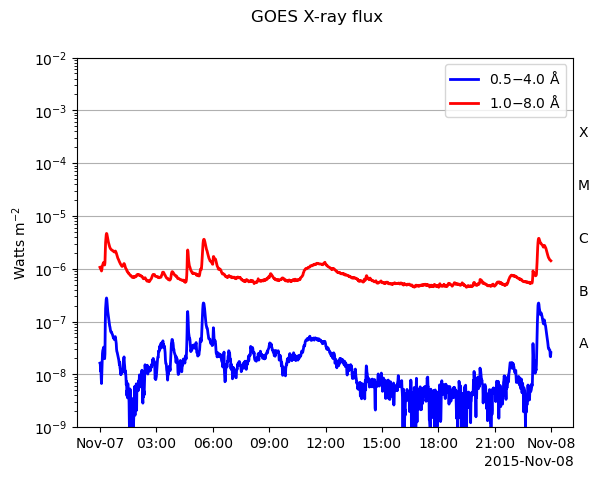

Se encontraron datos  GOES para 2015-11-07 00:00:00 - 2015-11-07 23:59:00. Día saltado.

Número de registros: 1440
Columnas disponibles: ['xrsa', 'xrsb', 'xrsa_quality', 'xrsb_quality']
2. Restar Background


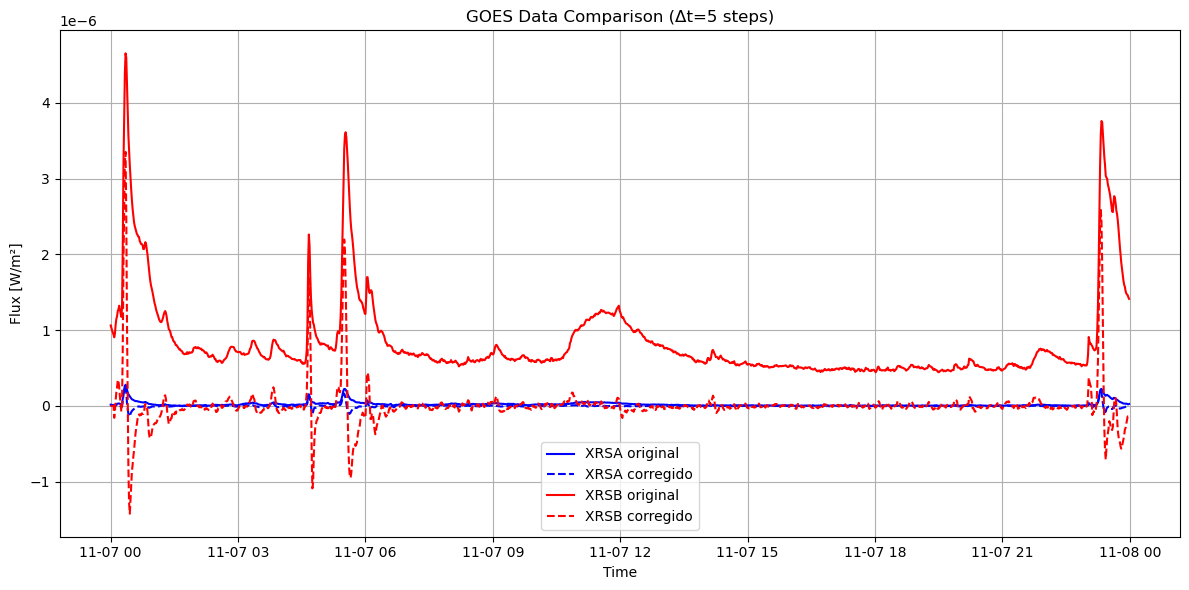

3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2015-11-07 00:00:00
End Date:			2015-11-07 23:59:00
Center Date:			2015-11-07 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.69E+01<br>emission_measure   6.38E+49
Units:			1 / cm3<br>MK
                     temperature  emission_measure
2015-11-07 00:00:00     2.667883      0.000000e+00
2015-11-07 00:01:00     2.667883      0.000000e+00
2015-11-07 00:02:00     2.667883      0.000000e+00
2015-11-07 00:03:00     2.667883      0.000000e+00
2015-11-07 00:04:00     2.667883      0.000000e+00
...                          ...               ...
2015-11-07 23:55:00     2.667883     -8.378580e+48
2015-11-07 23:56:00     2.667883     -6.428660e+48
2015-11-07 23:57:00     2.667883     -4.799126e+48
2015-11-07 23:58:00     2.667883     -4.884631e+48
2015-11-07

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.35file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2015-11-07 00:00:00
End Date:			2015-11-07 23:59:00
Center Date:			2015-11-07 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.82E+01<br>emission_measure   2.02E+50
Units:			1 / cm3<br>MK
                     temperature  emission_measure
2015-11-07 00:00:00     2.528493      0.000000e+00
2015-11-07 00:01:00     2.528493      0.000000e+00
2015-11-07 00:02:00     2.528493      0.000000e+00
2015-11-07 00:03:00     2.528493      0.000000e+00
2015-11-07 00:04:00     2.528493      0.000000e+00
...                          ...               ...
2015-11-07 23:55:00     2.528493     -2.661434e+49
2015-11-07 23:56:00     2.528493     -2.042047e+49
2015-11-07 23:57:00     2.528493     -1.524429e+49
2015-11-07 23:58:00     2.528493     -1.551590e+49
2015-

Files Downloaded: 100%|██████████| 4/4 [00:00<00:00,  7.24file/s]


Cargando datos de 2019-02-09 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2019-02-09 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2019-02-09 00:00:00
End Date:			2019-02-09 23:59:00
Center Date:			2019-02-09 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           1.34E-08<br>xrsb           5.92E-09<br>xrsa_quality   4.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2019-02-09 00:00:00  6.970683e-09  3.159197e-09             4             4
2019-02-09 00:01:00  6.749205e-09  2.301397e-09             4             4
2019-02-09 00:02:00  6.390424e-09  2.740821e-09           

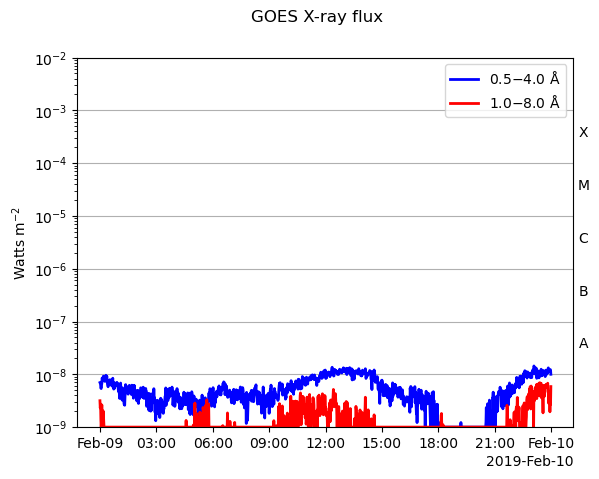

Se encontraron datos  GOES para 2019-02-09 00:00:00 - 2019-02-09 23:59:00. Día saltado.

Número de registros: 1440
Columnas disponibles: ['xrsa', 'xrsb', 'xrsa_quality', 'xrsb_quality']
2. Restar Background


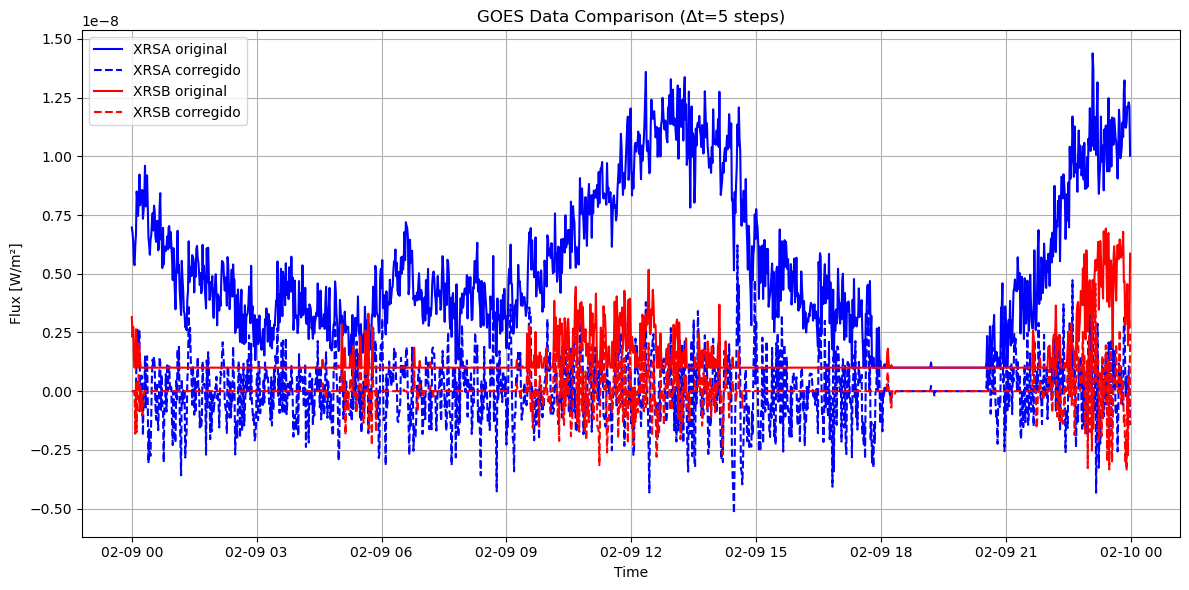

2025-09-15 17:05:29 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-15 17:05:30 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2019-02-09 00:00:00
End Date:			2019-02-09 23:59:00
Center Date:			2019-02-09 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   1.78E+47
Units:			1 / cm3<br>MK
                     temperature  emission_measure
2019-02-09 00:00:00     2.811526      0.000000e+00
2019-02-09 00:01:00     2.811526      0.000000e+00
2019-02-09 00:02:00     2.811526      0.000000e+00
2019-02-09 00:03:00     2.811526      0.000000e+00
2019-02-09 00:04:00     2.811526      0.000000e+00
...                          ...               ...
2019-02-09 23:55:00     2.811526     -1.862949e+45
2019-02-09 23:56:00     2.811526     -6.081176e+46
2019-02-09 23:57:00     2.811526      1.568713e+46
2019-02-09 23:58:00     2.811526     -3.173927e+46
2019-02-09

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.31file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2019-02-09 00:00:00
End Date:			2019-02-09 23:59:00
Center Date:			2019-02-09 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   5.83E+47
Units:			1 / cm3<br>MK
                     temperature  emission_measure
2019-02-09 00:00:00     2.637235      0.000000e+00
2019-02-09 00:01:00     2.637235      0.000000e+00
2019-02-09 00:02:00     2.637235      0.000000e+00
2019-02-09 00:03:00     2.637235      0.000000e+00
2019-02-09 00:04:00     2.637235      0.000000e+00
...                          ...               ...
2019-02-09 23:55:00     2.637235     -6.115139e+45
2019-02-09 23:56:00     2.637235     -1.996149e+47
2019-02-09 23:57:00     2.637235      5.149308e+46
2019-02-09 23:58:00     2.637235     -1.041843e+47
2019-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  4.54file/s]


Cargando datos de 2022-05-14 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2022-05-14 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2022-05-14 00:00:00
End Date:			2022-05-14 23:59:00
Center Date:			2022-05-14 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           3.53E-07<br>xrsb           4.66E-06<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa      xrsb  xrsa_quality  xrsb_quality
2022-05-14 00:00:00  3.314226e-08  0.000001             0             0
2022-05-14 00:01:00  3.316332e-08  0.000001             0             0
2022-05-14 00:02:00  3.074530e-08  0.000001             0             

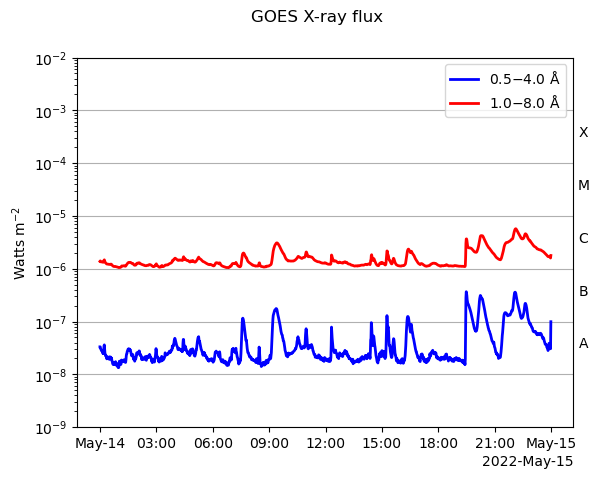

Se encontraron datos  GOES para 2022-05-14 00:00:00 - 2022-05-14 23:59:00. Día saltado.

Número de registros: 1440
Columnas disponibles: ['xrsa', 'xrsb', 'xrsa_quality', 'xrsb_quality']
2. Restar Background


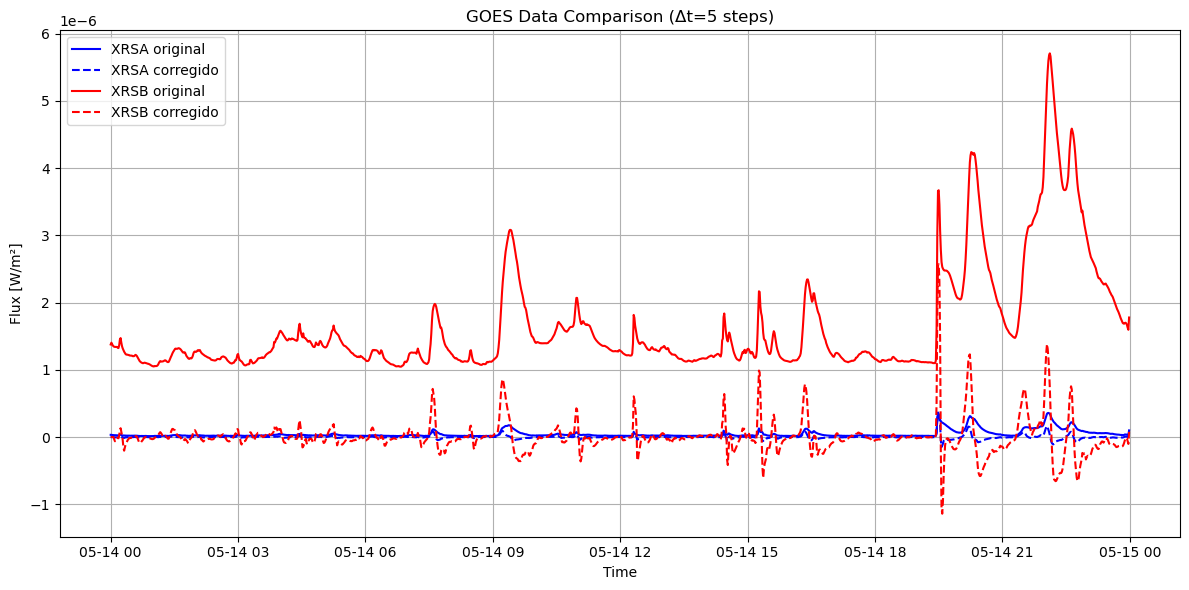

2025-09-15 17:05:39 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-15 17:05:40 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2022-05-14 00:00:00
End Date:			2022-05-14 23:59:00
Center Date:			2022-05-14 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        4.06E+01<br>emission_measure   3.46E+49
Units:			1 / cm3<br>MK
                     temperature  emission_measure
2022-05-14 00:00:00     2.811526      0.000000e+00
2022-05-14 00:01:00     2.811526      0.000000e+00
2022-05-14 00:02:00     2.811526      0.000000e+00
2022-05-14 00:03:00     2.811526      0.000000e+00
2022-05-14 00:04:00     2.811526      0.000000e+00
...                          ...               ...
2022-05-14 23:55:00     2.811526     -1.705650e+47
2022-05-14 23:56:00     2.811526     -4.710116e+47
2022-05-14 23:57:00     2.811526     -1.325133e+48
2022-05-14 23:58:00     2.811526     -2.273554e+48
2022-05-14

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2022-05-14 00:00:00
End Date:			2022-05-14 23:59:00
Center Date:			2022-05-14 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        6.20E+01<br>emission_measure   1.14E+50
Units:			1 / cm3<br>MK
                     temperature  emission_measure
2022-05-14 00:00:00     2.637235      0.000000e+00
2022-05-14 00:01:00     2.637235      0.000000e+00
2022-05-14 00:02:00     2.637235      0.000000e+00
2022-05-14 00:03:00     2.637235      0.000000e+00
2022-05-14 00:04:00     2.637235      0.000000e+00
...                          ...               ...
2022-05-14 23:55:00     2.637235     -5.598806e+47
2022-05-14 23:56:00     2.637235     -1.546098e+48
2022-05-14 23:57:00     2.637235     -4.349756e+48
2022-05-14 23:58:00     2.637235     -7.462954e+48
2022-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.29file/s]


Cargando datos de 2025-08-16 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2025-08-16 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-18
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2025-08-16 00:00:00
End Date:			2025-08-16 23:59:00
Center Date:			2025-08-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           2.90E-07<br>xrsb           2.70E-06<br>xrsa_quality   4.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2025-08-16 00:00:00  1.380513e-08  8.676176e-07             4             0
2025-08-16 00:01:00  1.725330e-08  8.595291e-07             4             0
2025-08-16 00:02:00  1.641115e-08  8.479012e-07           

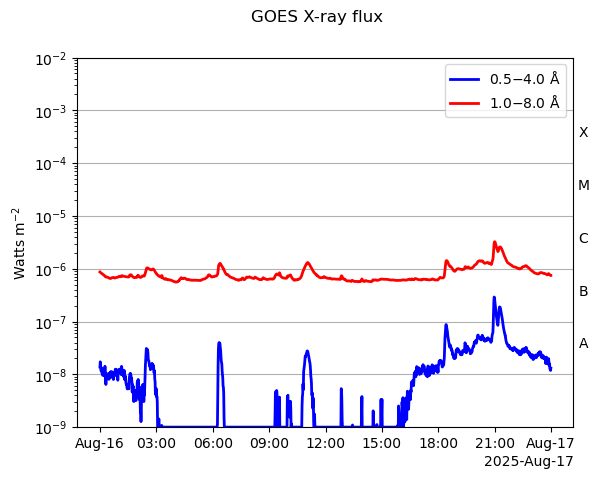

Se encontraron datos  GOES para 2025-08-16 00:00:00 - 2025-08-16 23:59:00. Día saltado.

Número de registros: 1440
Columnas disponibles: ['xrsa', 'xrsb', 'xrsa_quality', 'xrsb_quality']
2. Restar Background


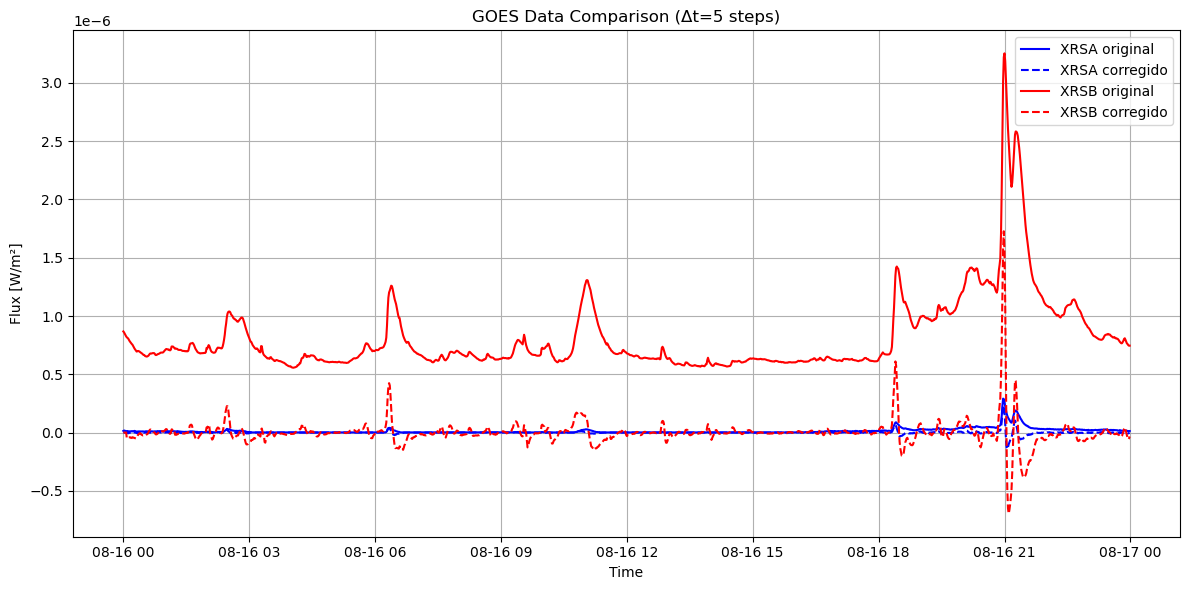

2025-09-15 17:05:50 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-15 17:05:51 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2025-08-16 00:00:00
End Date:			2025-08-16 23:59:00
Center Date:			2025-08-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        4.51E+01<br>emission_measure   2.57E+49
Units:			1 / cm3<br>MK
                     temperature  emission_measure
2025-08-16 00:00:00     2.825434      0.000000e+00
2025-08-16 00:01:00     2.825434      0.000000e+00
2025-08-16 00:02:00     2.825434      0.000000e+00
2025-08-16 00:03:00     2.825434      0.000000e+00
2025-08-16 00:04:00     2.825434      0.000000e+00
...                          ...               ...
2025-08-16 23:55:00     2.825434     -5.042100e+47
2025-08-16 23:56:00     2.825434     -9.629310e+47
2025-08-16 23:57:00     2.825434     -1.300831e+48
2025-08-16 23:58:00     2.825434     -1.116133e+48
2025-08-16

Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.77s/file]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2025-08-16 00:00:00
End Date:			2025-08-16 23:59:00
Center Date:			2025-08-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        7.35E+01<br>emission_measure   8.49E+49
Units:			1 / cm3<br>MK
                     temperature  emission_measure
2025-08-16 00:00:00     2.648176      0.000000e+00
2025-08-16 00:01:00     2.648176      0.000000e+00
2025-08-16 00:02:00     2.648176      0.000000e+00
2025-08-16 00:03:00     2.648176      0.000000e+00
2025-08-16 00:04:00     2.648176      0.000000e+00
...                          ...               ...
2025-08-16 23:55:00     2.648176     -1.661748e+48
2025-08-16 23:56:00     2.648176     -3.173576e+48
2025-08-16 23:57:00     2.648176     -4.287208e+48
2025-08-16 23:58:00     2.648176     -3.678492e+48
2025-

In [34]:
# Crear contenedores vacíos
all_df_full = pd.DataFrame()
all_df_flare_data = pd.DataFrame()
chunk_size=5

# Dividir los intervalos en bloques de "chunk_size" días
chunks = chunk_dataframe(df_intervals, chunk_size=chunk_size)

for i, chunk in enumerate(chunks, start=1):
    print(f"Procesando bloque {i}/{len(chunks)} con {len(chunk)} días...")
    
    # Crear carpeta para este bloque
    block_dir = os.path.join(output_dir, f"Block_{i}")
    os.makedirs(block_dir, exist_ok=True)

    # Contenedores para este bloque
    list_df_full = []
    list_df_flare_data = []
    
    for idx, row in chunk.iterrows():
        start_time = row["start_time"]
        end_time   = row["end_time"]

        try:
            results = download_goes_flare_data(start_time, end_time, 
                                                resolution="avg1m",  #resolución de descarga de los datos GOES (1min)
                                                Dif_time=5,            #Difference time Δt (for background)
                                                plot_diff=True)
            
        except Exception as e:
            print(f" Error en intervalo {start_time} - {end_time}: {e}")
            continue

        if results is None or results["df_flare_data"].empty:
            print(f"Saltando intervalo {start_time} - {end_time} (sin datos/flares).")
            continue

        # Acumular en listas
        list_df_full.append(results["df_full"])
        list_df_flare_data.append(results["df_flare_data"])
        
    # Guardar resultados del bloque
    if list_df_full:
        pd.concat(list_df_full).to_csv(os.path.join(block_dir, f"df_full_block{i}.csv"))
    if list_df_flare_data:
        pd.concat(list_df_flare_data).to_csv(os.path.join(block_dir, f"df_flare_data_block{i}.csv"))
    

    print(f" Bloque {i} terminado y guardado en {block_dir}")

In [35]:
# Unir cada salida
combine_blocks(output_dir, "df_full_block", f"all_df_full_{n}.csv")
combine_blocks(output_dir, "df_flare_data_block", f"all_df_flare_data_{n}.csv")


 all_df_full_15.csv creado con 18720 filas (desde 3 archivos).
 all_df_flare_data_15.csv creado con 100 filas (desde 3 archivos).


In [36]:
print(all_df_full)

Empty DataFrame
Columns: []
Index: []
